# TimeEval result analysis on the GutenTAG datasets

In [1]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

from IPython.display import display, Markdown, Latex

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [2]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "test-cases"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-11-01_runtime-gutentag-merged"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-11-02_runtime-benchmark'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/2021-11-01_runtime-gutentag-merged'),
 PosixPath('/home/projects/akita/results/2021-10-14_optim-extra'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-17_optim-extra2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/backup'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6'),
 PosixPath('/home/projects/akita/results/202


Selecting:
Data path: /home/projects/akita/data/test-cases
Result path: /home/projects/akita/results/2021-11-01_runtime-gutentag-merged


Load results and dataset metadata:

In [3]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# add dataset_name column
df["dataset_name"] = df["dataset"].str.split(".").str[0]

# aggregate runtime
df["overall_time"] = df["execute_main_time"].fillna(0) + df["train_main_time"].fillna(0)

# remove all duplicates (not necessary, but sometimes, we have some)
df = df.drop_duplicates()

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-11-01_runtime-gutentag-merged


Define utility functions

In [4]:
def load_scores_df(algorithm_name, dataset_id, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [5]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_name, use_plotly: bool = default_use_plotly, **kwargs):
    if not isinstance(algorithm_name, list):
        algorithms = [algorithm_name]
    else:
        algorithms = algorithm_name
    # construct dataset ID
    dataset_id = ("GutenTAG", f"{dataset_name}.unsupervised")

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[df["dataset_name"] == dataset_name, "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo in algorithms:
        algos.append(algo)
        # get algorithm metric results
        try:
            auroc[algo] = df.loc[(df["algorithm"] == algo) & (df["dataset_name"] == dataset_name), "ROC_AUC"].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} was not executed on {dataset_name}.")
            auroc[algo] = -1
            skip_algos.append(algo)
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[algo] = load_scores_df(algo, ("GutenTAG", f"{dataset_name}.{training_type}")).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name}.")
            df_scores[algo] = np.nan
            skip_algos.append(algo)
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=f"channel-{i}"), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for algo in algorithms:
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[algo], name=f"{algo}={auroc[algo]:.4f}"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique(algorithms))} on {dataset_name}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=f"channel-{i}")
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for algo in algorithms:
        axs[1].plot(df_scores.index, df_scores[algo], label=f"{algo}={auroc[algo]:.4f}")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique(algorithms))} on {dataset_name}")
    fig.tight_layout()
    return fig

def plot_boxplot(df, n_show = 20, title="Box plots", ax_label="values", fmt_label=lambda x: x, use_plotly=default_use_plotly):
    n_show = n_show // 2
    title = title + f" (worst {n_show} and best {n_show} algorithms)"
    
    if use_plotly:
        import plotly.offline as py
        import plotly.graph_objects as go
        import plotly.figure_factory as ff
        import plotly.express as px
        from plotly.subplots import make_subplots
        
        fig = go.Figure()
        for i, c in enumerate(df.columns):
            fig.add_trace(go.Box(
                x=df[c],
                name=fmt_label(c),
                boxpoints=False,
                visible=None if i < n_show or i > len(df.columns)-n_show-1 else "legendonly"
            ))
        fig.update_layout(
            title={"text": title, "xanchor": "center", "x": 0.5},
            xaxis_title=ax_label,
            legend_title="Algorithms"
        )
        return py.iplot(fig)
    else:
        df_boxplot = pd.concat([df.iloc[:, :n_show], df.iloc[:, -n_show:]])
        labels = df_boxplot.columns
        labels = [fmt_label(c) for c in labels]
        values = [df_boxplot[c].dropna().values for c in df_boxplot.columns]
        fig = plt.figure()
        ax = fig.gca()
        ax.boxplot(values, sym="", vert=True, meanline=True, showmeans=True, showfliers=False, manage_ticks=True)
        ax.set_ylabel(ax_label)
        ax.set_title(title)
        ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode="anchor")
        # add vline to separate bad and good algos
        ymin, ymax = ax.get_ylim()
        ax.vlines([n_show + 0.5], ymin, ymax, colors="black", linestyles="dashed")
        fig.tight_layout()
        return fig

def plot_algorithm_bars(df, y_name="ROC_AUC", title="Bar chart for algorithms", use_plotly=default_use_plotly, color="blue", legend=True):
    if use_plotly:
        fig = px.bar(df, x="algorithm", y=y_name)
        py.iplot(fig)
    else:
        fig = plt.figure()
        ax = fig.gca()
        ax.bar(df["algorithm"], df[y_name], label=y_name, color=color)
        ax.set_ylabel(y_name)
        ax.set_title(title)
        ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
        if legend:
            ax.legend()
        return fig

## Analyze overall results on the GutenTAG datasets

### Overview

In [6]:
df[["algorithm", "dataset_name", "status", "ROC_AUC", "AVERAGE_PRECISION", "PR_AUC", "RANGE_PR_AUC", "execute_main_time", "hyper_params"]]

,algorithm,dataset_name,status,ROC_AUC,AVERAGE_PRECISION,PR_AUC,RANGE_PR_AUC,execute_main_time,hyper_params
0,ARIMA,cbf-combined-diff-1,Status.OK,0.815319,0.454742,0.465248,0.453215,78.018341,"{""differencing_degree"": 1, ""distance_metric"": ..."
1,ARIMA,cbf-combined-diff-2,Status.OK,0.480169,0.068871,0.061556,0.077541,134.534048,"{""differencing_degree"": 1, ""distance_metric"": ..."
2,ARIMA,cbf-combined-diff-3,Status.OK,0.955978,0.241877,0.127965,0.136431,130.194427,"{""differencing_degree"": 1, ""distance_metric"": ..."
3,ARIMA,cbf-diff-count-1,Status.OK,0.439091,0.014368,0.008516,0.016521,72.464707,"{""differencing_degree"": 1, ""distance_metric"": ..."
4,ARIMA,cbf-diff-count-2,Status.OK,0.343218,0.011311,0.007510,0.012396,107.627002,"{""differencing_degree"": 1, ""distance_metric"": ..."
...,...,...,...,...,...,...,...,...,...
11472,Hybrid KNN,sinus-type-pattern-shift,Status.OK,0.000379,0.005532,0.005017,0.212436,18.216041,"{""anomaly_window_size"": 100, ""batch_size"": 64,..."
11473,Hybrid KNN,sinus-type-pattern,Status.OK,0.999984,0.998432,0.998424,0.993594,20.011246,"{""anomaly_window_size"": 100, ""batch_size"": 64,..."
11474,Hybrid KNN,sinus-type-platform,Status.OK,0.337553,0.007539,0.007034,0.084941,21.798608,"{""anomaly_window_size"": 100, ""batch_size"": 64,..."
11475,Hybrid KNN,sinus-type-trend,Status.OK,0.256364,0.006496,0.006429,0.058526,20.110722,"{""anomaly_window_size"": 100, ""batch_size"": 64,..."


### Algorithm problems grouped by algorithm training type

In [7]:
index_columns = ["algo_training_type", "algo_input_dimensionality", "algorithm"]
df_error_counts = df.pivot_table(index=index_columns, columns=["status"], values="repetition", aggfunc="count")
df_error_counts = df_error_counts.fillna(value=0).astype(np.int64)
df_error_counts = df_error_counts.reset_index().sort_values(by=["algo_input_dimensionality", "Status.ERROR"], ascending=False).set_index(index_columns)
df_error_counts["ALL"] = df_error_counts["Status.ERROR"] + df_error_counts["Status.OK"] + df_error_counts["Status.TIMEOUT"]

for tpe in ["SEMI_SUPERVISED", "SUPERVISED", "UNSUPERVISED"]:
    if tpe in df_error_counts.index:
        print(tpe)
        if default_use_plotly:
            py.iplot(ff.create_table(df_error_counts.loc[tpe], index=True))
        else:
            display(df_error_counts.loc[tpe])

SEMI_SUPERVISED


status                                                  Status.ERROR  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                Bagel                                  168   
                          TARZAN                                  33   
                          Donut                                    0   
                          ImageEmbeddingCAE                        0   
                          OceanWNN                                 0   
                          Random Forest Regressor (RR)             0   
                          SR-CNN                                   0   
                          XGBoosting (RR)                          0   
MULTIVARIATE              Hybrid KNN                             181   
                          LSTM-AD                                110   
                          EncDec-AD                               39   
                          LaserDBN                                25   
                          DeepAnT                                 10   
                          OmniAnomaly                              4   
                          HealthESN                                0   
                          Random Black Forest (RR)                 0   
                          RobustPCA                                0   
                          TAnoGan                                  0   
                          Telemanom                                0   

status                                                  Status.OK  \
algo_input_dimensionality algorithm                                 
UNIVARIATE                Bagel                               168   
                          TARZAN                              135   
                          Donut                               168   
                          ImageEmbeddingCAE                   168   
                          OceanWNN                            168   
                          Random Forest Regressor (RR)        168   
                          SR-CNN                              168   
                          XGBoosting (RR)                     168   
MULTIVARIATE              Hybrid KNN                          205   
                          LSTM-AD                              75   
                          EncDec-AD                            17   
                          LaserDBN                            168   
                          DeepAnT                             183   
                          OmniAnomaly                         189   
                          HealthESN                           167   
                          Random Black Forest (RR)            179   
                          RobustPCA                           193   
                          TAnoGan                              72   
                          Telemanom                           193   

status                                                  Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                          
UNIVARIATE                Bagel                                      0  336  
                          TARZAN                                     0  168  
                          Donut                                      0  168  
                          ImageEmbeddingCAE                          0  168  
                          OceanWNN                                   0  168  
                          Random Forest Regressor (RR)               0  168  
                          SR-CNN                                     0  168  
                          XGBoosting (RR)                            0  168  
MULTIVARIATE              Hybrid KNN                                 0  386  
                          LSTM-AD                                    8  193  
                          EncDec-AD                                137  193  
                       

SUPERVISED


status                                                   Status.ERROR  \
algo_input_dimensionality algorithm                                     
MULTIVARIATE              MultiHMM                                 98   
                          Normalizing Flows                        10   
                          Hybrid Isolation Forest (HIF)             0   

status                                                   Status.OK  \
algo_input_dimensionality algorithm                                  
MULTIVARIATE              MultiHMM                              95   
                          Normalizing Flows                     68   
                          Hybrid Isolation Forest (HIF)        193   

status                                                   Status.TIMEOUT  ALL  
algo_input_dimensionality algorithm                                           
MULTIVARIATE              MultiHMM                                    0  193  
                          Normalizing Flows                         115  193  
                          Hybrid Isolation Forest (HIF)               0  193

UNSUPERVISED


status                                                     Status.ERROR  \
algo_input_dimensionality algorithm                                       
UNIVARIATE                SAND                                       28   
                          Left STAMPi                                16   
                          GrammarViz                                 12   
                          STAMP                                      12   
                          STOMP                                      12   
                          VALMOD                                      8   
                          Series2Graph                                4   
                          ARIMA                                       0   
                          DSPOT                                       0   
                          DWT-MLEAD                                   0   
                          FFT                                         0   
                          HOT SAX                                     0   
                          MedianMethod                                0   
                          NormA                                       0   
                          NumentaHTM                                  0   
                          PCI                                         0   
                          PST                                         0   
                          PhaseSpace-SVM                              0   
                          S-H-ESD (Twitter)                           0   
                          SSA                                         0   
                          Spectral Residual (SR)                      0   
                          Subsequence IF                              0   
                          Subsequence LOF                             0   
                          TSBitmap                                    0   
                          Triple ES (Holt-Winter's)                   0   
MULTIVARIATE              DBStream                                  329   
                          CBLOF                                       0   
                          COF                                         0   
                          COPOD                                       0   
                          Extended Isolation Forest (EIF)             0   
                          HBOS                                        0   
                          IF-LOF                                      0   
                          Isolation Forest (iForest)                  0   
                          KNN                                         0   
                          LOF                                         0   
                          PCC                                         0   
                          Torsk                                       0   
                          k-Means                                     0   

status                                                     Status.OK  \
algo_input_dimensionality algorithm                                    
UNIVARIATE                SAND                                   140   
                          Left STAMPi                            152   
                          GrammarViz                             156   
                          STAMP                                  156   
                          STOMP                                  156   
                          VALMOD                                 160   
                          Series2Graph                           164   
                          ARIMA                                  168   
                          DSPOT                                  161   
                          DWT-MLEAD                              168   
                          FFT                                    168   
                          HOT SAX                              

#### Very slow algorithms

Algorithms, for which more than 50% of all executions ran into the timeout. You can adjust the timeout threshold.

In [8]:
timeout_threshold = 0.5
df_error_counts[df_error_counts["Status.TIMEOUT"] > timeout_threshold*df_error_counts["ALL"]].sort_index(level=[0, 1])

status                                                          Status.ERROR  \
algo_training_type algo_input_dimensionality algorithm                         
SEMI_SUPERVISED    MULTIVARIATE              EncDec-AD                    39   
                                             TAnoGan                       0   
SUPERVISED         MULTIVARIATE              Normalizing Flows            10   

status                                                          Status.OK  \
algo_training_type algo_input_dimensionality algorithm                      
SEMI_SUPERVISED    MULTIVARIATE              EncDec-AD                 17   
                                             TAnoGan                   72   
SUPERVISED         MULTIVARIATE              Normalizing Flows         68   

status                                                          Status.TIMEOUT  \
algo_training_type algo_input_dimensionality algorithm                           
SEMI_SUPERVISED    MULTIVARIATE              EncDec-AD                     137   
                                             TAnoGan                       121   
SUPERVISED         MULTIVARIATE              Normalizing Flows             115   

status                                                          ALL  
algo_training_type algo_input_dimensionality algorithm               
SEMI_SUPERVISED    MULTIVARIATE              EncDec-AD          193  
                                             TAnoGan            193  
SUPERVISED         MULTIVARIATE              Normalizing Flows  193

#### Broken algorithms

Algorithms, which failed for at least 50% of the executions. You can adjust the error threshold.

In [9]:
error_threshold = 0.5
df_error_counts[df_error_counts["Status.ERROR"] > error_threshold*df_error_counts["ALL"]].sort_index(level=[0, 1])

,,status,Status.ERROR,Status.OK,Status.TIMEOUT,ALL
algo_training_type,algo_input_dimensionality,algorithm,,,,
SEMI_SUPERVISED,MULTIVARIATE,LSTM-AD,110,75,8,193
SUPERVISED,MULTIVARIATE,MultiHMM,98,95,0,193
UNSUPERVISED,MULTIVARIATE,DBStream,329,57,0,386


Inspect errors of a specific algorithm:

In [10]:
from collections import defaultdict

algo = "Normalizing Flows"

executions = [f for f in (result_path / algo).glob("**/execution.log") if not (f.parent / "anomaly_scores.ts").is_file()]
errors = defaultdict(int)
for x in executions:
    with x.open() as fh:
        log = fh.read()
    if "TimeoutError" in log:
        errors["TimeoutError"] += 1
    elif "NameError: name 'nan' is not defined" in log:
        errors["Could not load model, bc. empty distribution fit."] += 1
    elif "ValueError: Expected 2D array, got 1D array instead" in log:
        errors["Wrong shape error"] += 1
    elif "status code '139'" in log:
        errors["Segfault"] += 1
    elif "status code '137'" in log:
        errors["OOM"] += 1
    else:
        print("---------------------------------------------------------------------------------")
        print(log)

print("\nSummary")
for err_tpe in errors:
    print(f"  {errors[err_tpe]} {err_tpe}")


Summary
  115 TimeoutError
  10 OOM


### Remove some duplicated entries

Some algorithms were run multiple times per dataset, because we made a mistake with the parameter configuration for the first run. For example consider these two runs of Bagel:

In [11]:
df_bagel_duplicates = df[(df["algorithm"] == "Bagel") & (df["dataset_name"] == "sinus-type-mean")][["algorithm", "dataset_name", "hyper_params_id", "hyper_params", "status"]]
display(df_bagel_duplicates)
print("Full parameter lists:")
params = df_bagel_duplicates["hyper_params"].to_list()
for param_set in params:
    print(f"  {param_set}")

,algorithm,dataset_name,hyper_params_id,hyper_params,status
330,Bagel,sinus-type-mean,09c6fa6b38784d7abfb54e09ed29e693,"{""batch_size"": 64, ""cuda"": false, ""dropout"": 0...",Status.ERROR
11085,Bagel,sinus-type-mean,29d3610507d5a991bf82ff9bfc85b523,"{""batch_size"": 64, ""cuda"": false, ""dropout"": 0...",Status.OK


Full parameter lists:
  {"batch_size": 64, "cuda": false, "dropout": 0.1, "early_stopping_delta": 0.05, "early_stopping_patience": 10, "epochs": 500, "hidden_layer_shape": 100, "latent_size": 6, "random_state": 42, "split": 0.8, "window_size": 40}
  {"batch_size": 64, "cuda": false, "dropout": 0.1, "early_stopping_delta": 0.05, "early_stopping_patience": 10, "epochs": 500, "hidden_layer_shape": [100, 100], "latent_size": 6, "random_state": 42, "split": 0.8, "window_size": 40}


We want to consider only the best run for each `algorithm`-`dataset_name`-combination (over all `hyper_params` and `repetition`s) for the analysis in this notebook. Therefore, we filter out the other runs:

In [12]:
def filter_groups(group):
    if len(group) > 1:
        group = group.sort_values(by="ROC_AUC", ascending=False)
    return group[:1]

df_grouped = df.groupby(by=["algorithm", "collection", "dataset_name"])
df_grouped = df_grouped.apply(filter_groups)
df = df_grouped.reset_index(drop=True)
df = df.sort_values(by=["algorithm", "dataset_name"])

### Algorithm quality assessment based on ROC_AUC

In [13]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_scores = df.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_overall_scores.columns = aggregations
df_overall_scores = df_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_asl = df.pivot(index="algorithm", columns="dataset_name", values="ROC_AUC")
df_asl = df_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_asl[dominant_aggregation] = df_asl.agg(dominant_aggregation, axis=1)
df_asl = df_asl.sort_values(by=dominant_aggregation, ascending=True)
df_asl = df_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_scores.T)

algorithm,Subsequence LOF,PhaseSpace-SVM,DWT-MLEAD,EncDec-AD,SAND,Donut,GrammarViz,Left STAMPi,STOMP,STAMP,Torsk,k-Means,Normalizing Flows,Telemanom,DeepAnT,VALMOD,Series2Graph,Random Forest Regressor (RR),HealthESN,XGBoosting (RR),ImageEmbeddingCAE,ARIMA,Random Black Forest (RR),PST,NormA,SSA,Subsequence IF,LSTM-AD,HOT SAX,OceanWNN,DBStream,PCI,Triple ES (Holt-Winter's),NumentaHTM,LaserDBN,FFT,MedianMethod,TSBitmap,OmniAnomaly,KNN,Extended Isolation Forest (EIF),CBLOF,Isolation Forest (iForest),HBOS,Hybrid Isolation Forest (HIF),IF-LOF,LOF,Spectral Residual (SR),S-H-ESD (Twitter),DSPOT,COF,COPOD,PCC,Bagel,RobustPCA,SR-CNN,TARZAN,MultiHMM,TAnoGan,Hybrid KNN
min,0.341819,0.307866,0.125859,0.49555,0.167172,0.151962,0.207808,0.126879,0.009910,0.009910,0.077172,0.000000,0.004875,0.077962,0.000072,0.055046,0.069038,0.405782,0.107862,0.347727,0.106465,0.050505,0.130278,0.016049,0.013301,0.114735,0.000020,0.070397,0.147374,0.152038,0.102123,0.022453,0.239108,0.377848,0.119141,0.014141,0.004040,0.132703,0.080331,0.000000,0.000000,0.039293,0.000051,0.144394,0.054343,0.000101,0.164697,0.002450,0.462366,0.273283,0.000000,0.000051,0.055375,0.058306,0.000000,0.500000,0.000571,0.047605,0.000960,0.000001
mean,0.929827,0.910840,0.896714,0.89290,0.891414,0.887190,0.883790,0.882339,0.881738,0.879707,0.876505,0.860521,0.858959,0.856924,0.855186,0.853179,0.852389,0.851052,0.847801,0.845629,0.840897,0.808748,0.808323,0.796201,0.780556,0.762730,0.755168,0.744680,0.729221,0.724905,0.709822,0.690935,0.668414,0.664900,0.650482,0.641255,0.641156,0.634313,0.633785,0.607938,0.605765,0.602738,0.597933,0.594771,0.592918,0.583721,0.573517,0.567872,0.557439,0.554006,0.550940,0.536997,0.532785,0.521089,0.516785,0.502262,0.478378,0.473171,0.467900,0.451561
median,0.995447,0.976925,0.970002,0.99990,0.983695,0.967975,0.988387,0.983149,0.987923,0.987923,0.977390,0.996880,0.993047,0.979182,0.997640,0.958518,0.939665,0.882308,0.919747,0.880401,0.939670,0.884476,0.842815,0.858833,0.926484,0.836139,0.837340,0.859696,0.756453,0.751371,0.739981,0.657851,0.653662,0.634826,0.653622,0.591500,0.561343,0.621838,0.654534,0.605366,0.591108,0.558463,0.583551,0.584383,0.576551,0.556328,0.531862,0.544668,0.500000,0.501244,0.516588,0.526104,0.508369,0.548433,0.500000,0.500000,0.494000,0.480316,0.468382,0.444087
max,1.000000,0.999928,0.999992,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999990,1.000000,1.000000,0.999995,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998586,1.000000,1.000000,1.000000,1.000000,0.999800,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,0.999600,0.999650,1.000000,1.000000,0.998600,0.998564,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.934293,1.000000,0.880000,0.999784,1.000000,0.998550,1.000000


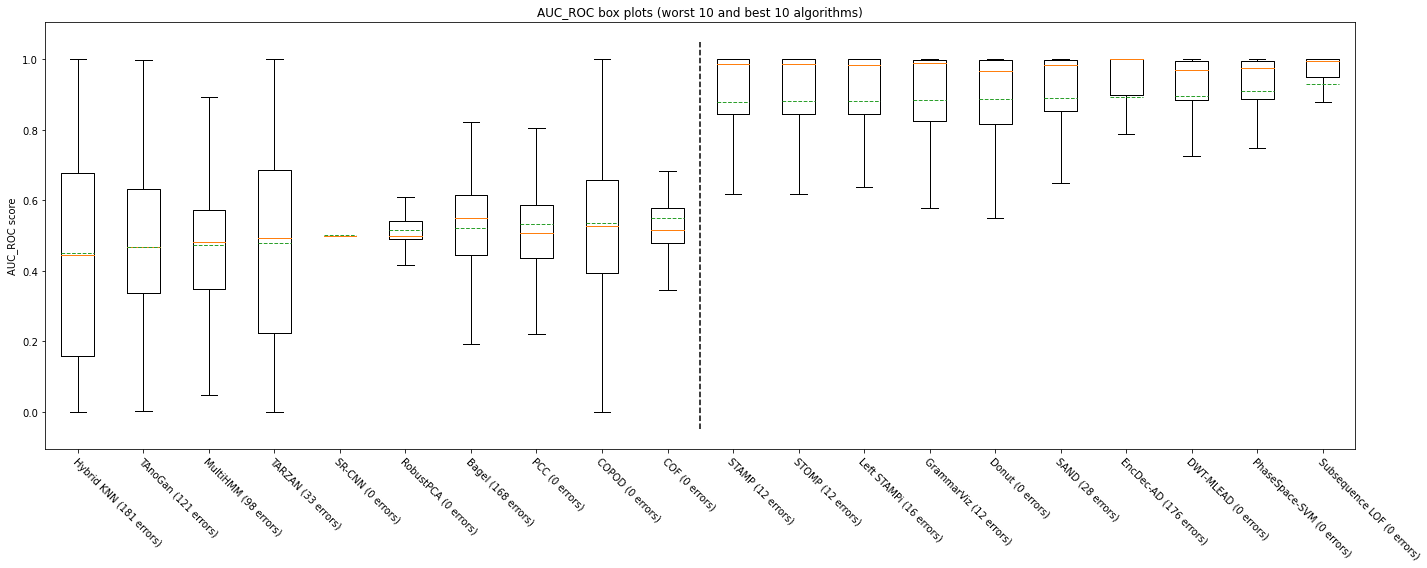

In [14]:
n_show = 20
error_count_lut = (df_error_counts["Status.ERROR"] + df_error_counts["Status.TIMEOUT"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
fmt_label = lambda c: f"{c} ({error_count_lut[c]} errors)"

fig = plot_boxplot(df_asl, title="AUC_ROC box plots", ax_label="AUC_ROC score", fmt_label=fmt_label)

#### Best algorithms (based on mean ROC_AUC)

In [15]:
df_overall_scores.head()

,min,mean,median,max
algorithm,,,,
Subsequence LOF,0.341819,0.929827,0.995447,1.000000
PhaseSpace-SVM,0.307866,0.910840,0.976925,0.999928
DWT-MLEAD,0.125859,0.896714,0.970002,0.999992
EncDec-AD,0.495550,0.892900,0.999900,1.000000
SAND,0.167172,0.891414,0.983695,1.000000


#### Worst algorithms (based on mean ROC_AUC)

In [16]:
df_overall_scores.tail()

,min,mean,median,max
algorithm,,,,
SR-CNN,0.500000,0.502262,0.500000,0.880000
TARZAN,0.000571,0.478378,0.494000,0.999784
MultiHMM,0.047605,0.473171,0.480316,1.000000
TAnoGan,0.000960,0.467900,0.468382,0.998550
Hybrid KNN,0.000001,0.451561,0.444087,1.000000


#### Scores of best algorithms

Please select a dataset (and algorithm if needed):

/tmp/ipykernel_6139/3316162823.py:42: UserWarning: No anomaly scores found! Probably EncDec-AD was not executed on poly-same-count-2.
  warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name}.")


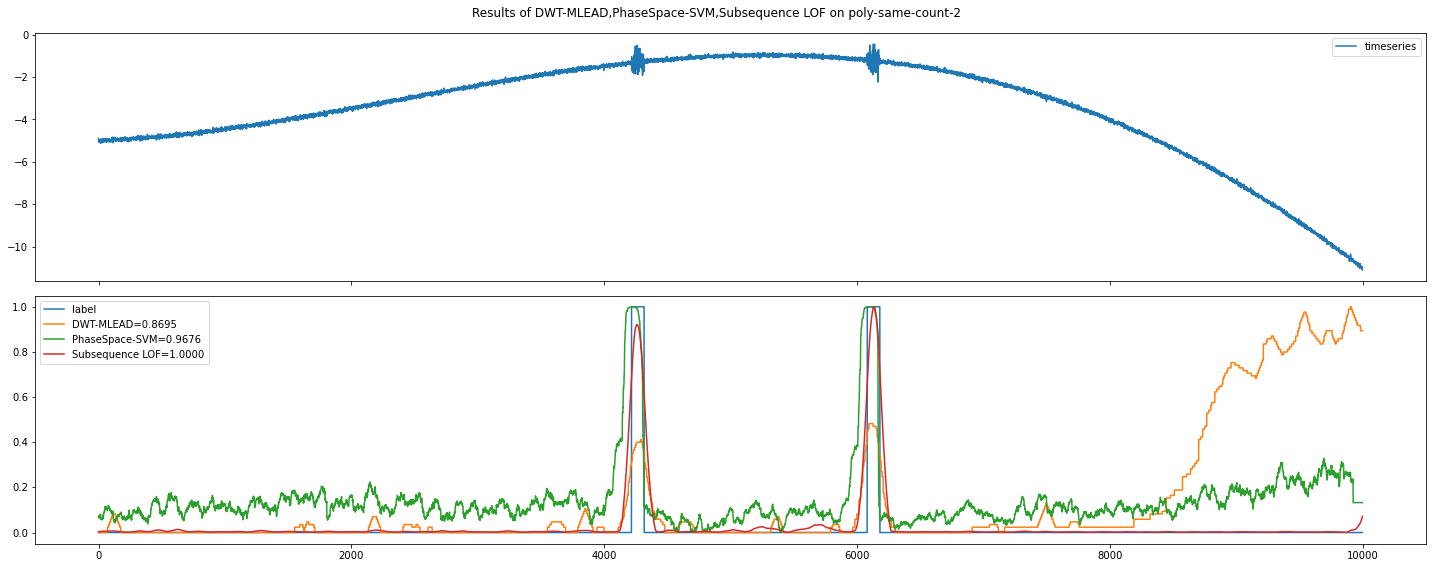

In [17]:
dataset_name = "poly-same-count-2"
algorithm_name = None
n_algos = 4

fig = plot_scores(algorithm_name if algorithm_name else df_asl.columns[-n_algos:].to_list(), dataset_name)

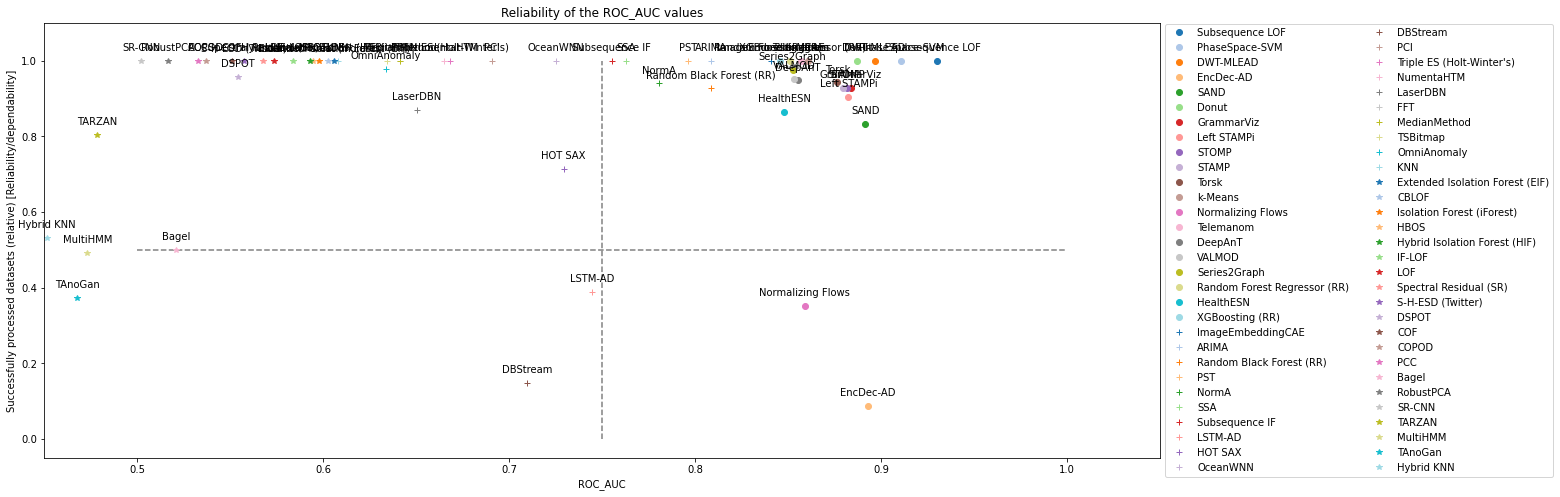

In [18]:
dataset_count_lut = (df_error_counts["Status.OK"] / df_error_counts["ALL"]).reset_index().set_index("algorithm").drop(columns=["algo_training_type", "algo_input_dimensionality"]).iloc[:, 0]
algo_auroc = df_overall_scores["mean"]
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

fig = plt.figure()
ax = fig.gca()
ax.set_prop_cycle(cycler)
for c in df_overall_scores.index:
    x = algo_auroc[c]
    y = dataset_count_lut[c]
    ax.plot(x, y, label=c, linestyle="")
    ax.annotate(c, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")

# add vline to separate bad and good algos
ax.vlines([0.75], 0, 1, colors="grey", linestyles="dashed")
ax.hlines([0.5], 0.5, 1, colors="grey", linestyles="dashed")
ax.set_xlabel("ROC_AUC")
ax.set_ylabel("Successfully processed datasets (relative) [Reliability/dependability]")
ax.set_title("Reliability of the ROC_AUC values")
ax.set_xlim(0.45, 1.05)
ax.set_ylim(-0.05, 1.1)
ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.show()

### Runtime-weighted AUC_ROC scores

/tmp/ipykernel_6139/994922933.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


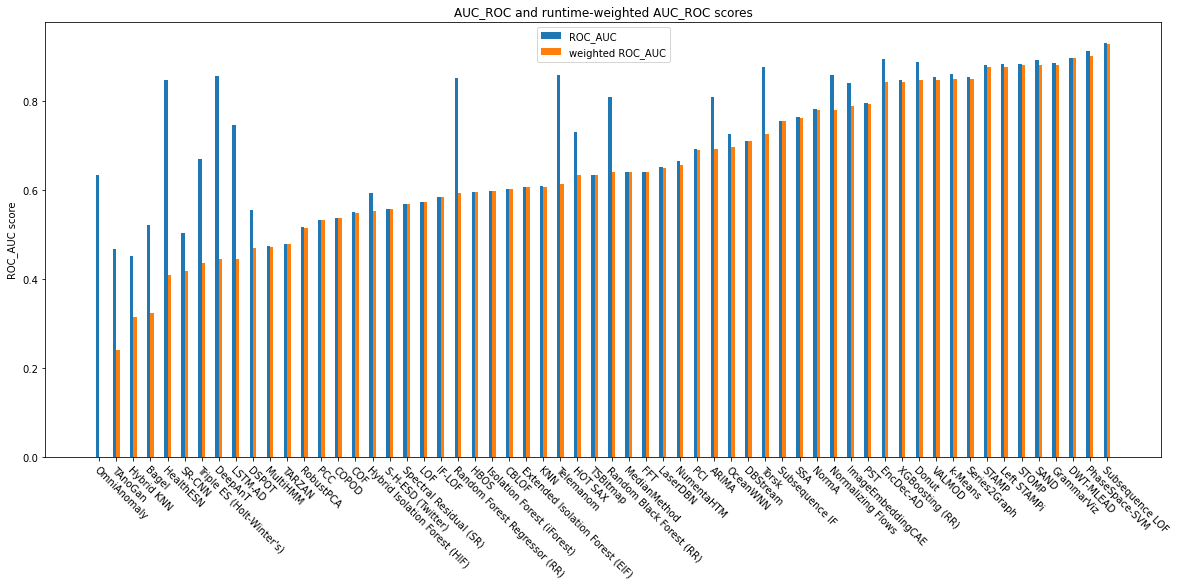

In [19]:
df_tmp = df.pivot_table(index="algorithm", values=["ROC_AUC", "overall_time"], aggfunc="mean")

from sklearn.preprocessing import MinMaxScaler
df_tmp["overall_time"] = 1 - MinMaxScaler(feature_range=(1e-6, 1)).fit_transform(df_tmp["overall_time"].values.reshape(-1, 1)).reshape(-1)
df_tmp = df_tmp.replace(0, np.nan)
df_tmp["weighted ROC_AUC"] = df_tmp["ROC_AUC"] * df_tmp["overall_time"]

df_tmp = df_tmp.sort_values(by="weighted ROC_AUC", ascending=True, na_position="first")
df_tmp.reset_index(drop=False, inplace=True)

if default_use_plotly:
    fig = px.bar(df_tmp, x="algorithm", y=["ROC_AUC", "weighted ROC_AUC"], hover_data=["overall_time"], barmode="group")
    py.iplot(fig)
else:
    fig = plt.figure()
    ax = fig.gca()
    ax.bar(df_tmp["algorithm"], df_tmp["ROC_AUC"], label="ROC_AUC", width=-0.2, align="edge")
    ax.bar(df_tmp["algorithm"], df_tmp["weighted ROC_AUC"], label="weighted ROC_AUC", width=0.2, align="edge")
    ax.set_ylabel("ROC_AUC score")
    ax.set_title(f"AUC_ROC and runtime-weighted AUC_ROC scores")
    ax.set_xticklabels(df_tmp["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")
    ax.legend()
    fig.show()

### Algorithm runtime assessment

In [20]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_overall_runtime = df.pivot_table(index="algorithm", values="overall_time", aggfunc=aggregations)
df_overall_runtime.columns = aggregations
df_overall_runtime = df_overall_runtime.sort_values(by=dominant_aggregation, ascending=True)


df_arl = df.pivot(index="algorithm", columns="dataset_name", values="overall_time")
df_arl = df_arl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_arl[dominant_aggregation] = df_arl.agg(dominant_aggregation, axis=1)
df_arl = df_arl.sort_values(by=dominant_aggregation, ascending=True)
df_arl = df_arl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_overall_runtime.T)

algorithm,MedianMethod,TSBitmap,DBStream,FFT,Spectral Residual (SR),PCI,KNN,Extended Isolation Forest (EIF),DWT-MLEAD,LOF,PCC,COPOD,NormA,IF-LOF,TARZAN,HBOS,LaserDBN,Isolation Forest (iForest),STOMP,CBLOF,Subsequence IF,S-H-ESD (Twitter),Subsequence LOF,SSA,GrammarViz,Series2Graph,PST,MultiHMM,STAMP,XGBoosting (RR),RobustPCA,COF,Left STAMPi,VALMOD,PhaseSpace-SVM,SAND,NumentaHTM,k-Means,OceanWNN,Donut,EncDec-AD,ImageEmbeddingCAE,Hybrid Isolation Forest (HIF),Normalizing Flows,HOT SAX,ARIMA,DSPOT,SR-CNN,Torsk,Random Black Forest (RR),Telemanom,Random Forest Regressor (RR),Hybrid KNN,Triple ES (Holt-Winter's),Bagel,LSTM-AD,DeepAnT,TAnoGan,HealthESN,OmniAnomaly
min,2.159865,2.064207,0.000000,2.899452,2.819950,4.067311,5.284291,5.283280,5.226329,5.262959,5.510329,6.192219,0.000000,6.130269,0.000000,7.752584,0.000000,8.042888,0.000000,8.148782,8.724064,9.809725,6.608140,9.577559,0.000000,0.000000,6.501227,0.000000,0.000000,29.906653,11.546304,25.713517,0.000000,0.000000,24.904922,0.000000,72.034193,5.031306,133.379622,234.080284,0.000000,21.086584,291.881033,0.000000,0.000000,72.230898,0.000000,183.110655,0.000000,0.000000,210.993799,1146.329453,244.669913,1645.172287,512.062849,0.000000,0.000000,0.000000,0.000000,0.000000
mean,3.357909,3.366816,4.435815,4.452780,4.516284,5.807167,7.014991,7.062672,7.255415,7.291739,7.452889,7.986386,8.450824,8.958186,9.068454,10.022887,10.666948,10.736897,11.112287,13.497440,13.588625,14.026796,18.046027,19.169588,21.719735,22.447782,23.735618,32.268508,34.116674,36.007536,36.813518,40.529018,48.621677,52.483397,80.033480,82.575354,90.162186,94.833612,280.199899,330.805080,414.236521,443.651772,491.928634,655.773497,946.034175,1034.336597,1094.711921,1204.940595,1227.902592,1474.960501,2029.342347,2156.603474,2165.227491,2474.284741,2704.557220,2870.718778,3423.834049,3446.114397,3691.433432,7119.091375
median,2.803844,2.707184,0.000000,3.642380,4.051195,5.223487,6.554506,6.423903,6.601982,6.635359,6.859591,7.640504,6.878798,8.575966,10.313941,9.409595,10.764423,10.564268,11.397201,10.193027,13.665167,13.836498,21.237884,19.180510,21.998144,21.437856,27.676518,0.000000,26.277267,35.469536,14.046445,41.130947,53.768552,60.273393,58.834254,46.420151,89.149608,68.199403,236.968527,345.898638,0.000000,339.745630,487.041917,0.000000,630.093527,613.081530,112.831327,1195.450227,1140.126455,1433.324641,1539.159618,1950.915196,1610.582998,2348.723657,2376.360765,0.000000,3125.748313,0.000000,3853.175224,7282.192955
max,6.849601,6.889920,448.969613,17.699763,8.896451,9.946476,13.022392,11.055569,10.491374,16.073738,13.165408,16.150058,31.199657,17.327040,18.316564,14.726178,19.279641,14.734662,16.860051,73.895860,22.824507,20.152909,55.974016,47.948269,69.347936,50.963915,39.316236,528.970243,370.644283,44.439480,498.808194,65.982386,58.196545,102.336435,303.518476,579.206285,134.130346,638.594660,732.110277,436.714325,7697.891523,1551.644747,697.237740,4973.893202,6047.012899,5752.065236,6626.679701,3353.644448,5873.876492,7103.031775,7290.177676,3689.310230,7229.453087,5494.864628,7644.951972,7762.513953,7227.186167,11116.606985,8245.564678,7302.553429


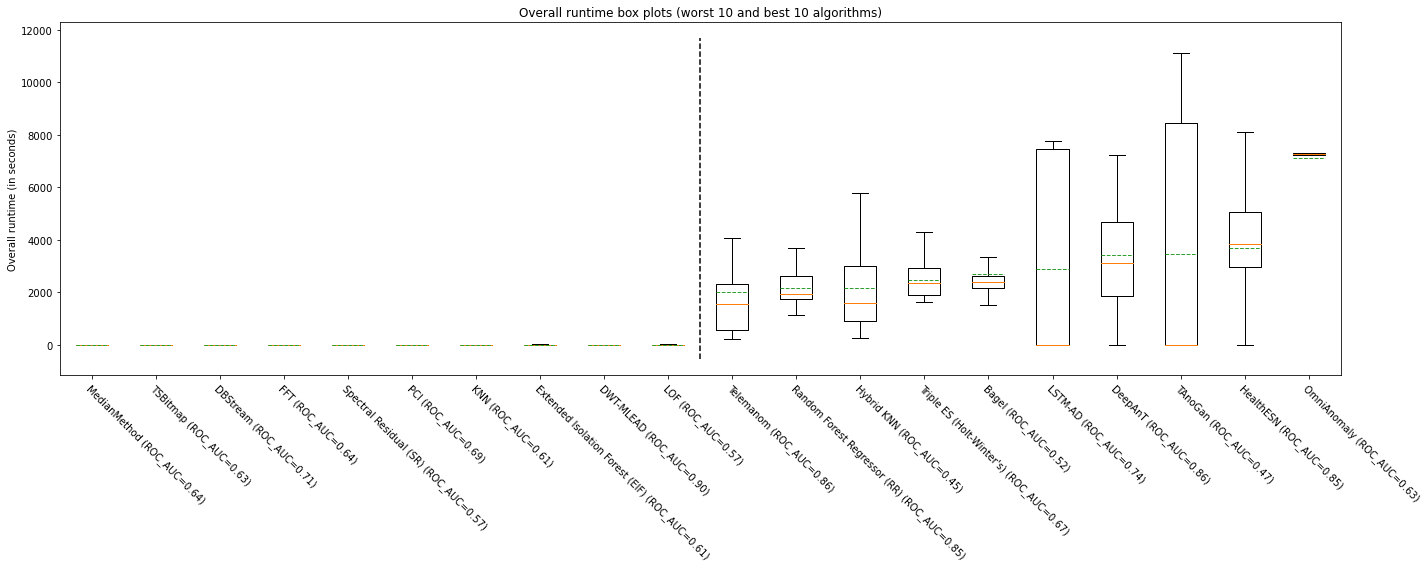

In [21]:
n_show = 20
n_show = n_show // 2
fmt_label = lambda c: f"{c} (ROC_AUC={df_overall_scores.loc[c, 'mean']:.2f})"

fig = plot_boxplot(df_arl, title="Overall runtime box plots", ax_label="Overall runtime (in seconds)", fmt_label=fmt_label)

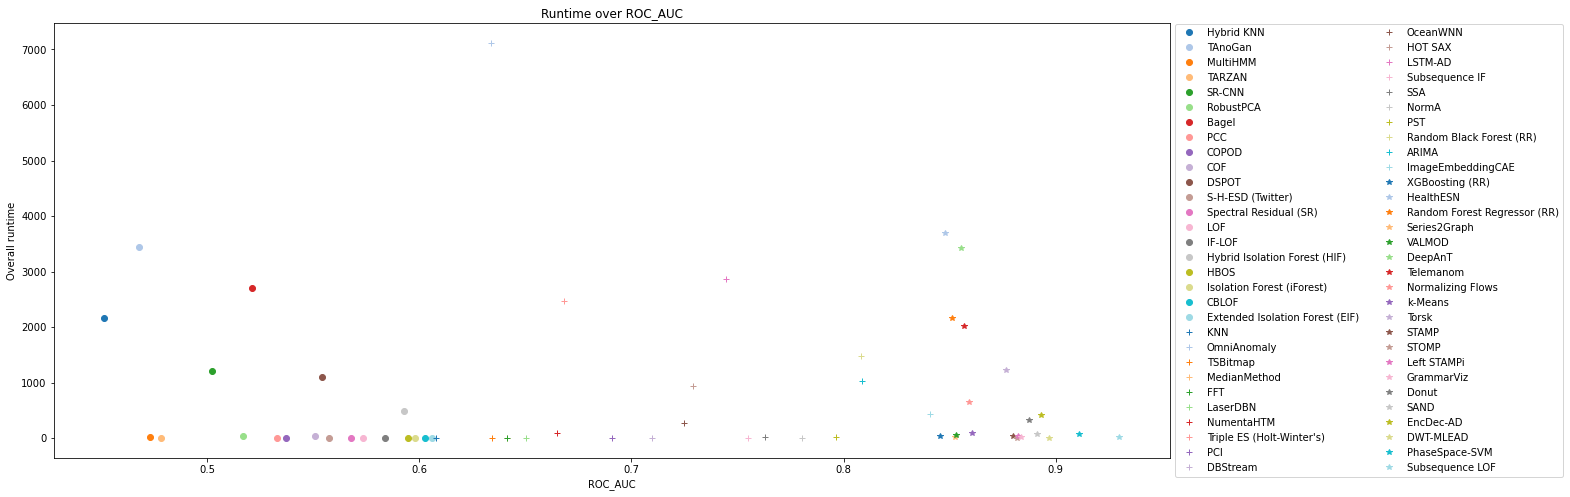

In [22]:
df_tmp = df.groupby(by="algorithm")[["ROC_AUC", "overall_time"]].mean().sort_values("ROC_AUC").T
cycler = plt.cycler(marker=["o", "+", "*", "x", ".", "X"]) * plt.cycler(color=plt.get_cmap("tab20").colors)

fig = plt.figure()
ax = fig.gca()
ax.set_prop_cycle(cycler)
for c in df_tmp:
    x = df_tmp.loc["ROC_AUC", c]
    y = df_tmp.loc["overall_time", c]
    ax.plot(x, y, label=c, linestyle="")
    #ax.annotate(c, (x, y), textcoords="offset points", xytext=(0, 10), ha="center")
ax.set_ylabel("Overall runtime")
ax.set_xlabel("ROC_AUC")
ax.set_title("Runtime over ROC_AUC")
ax.legend(ncol=2, loc="upper left", bbox_to_anchor=(1, 1.01))
fig.show()

## Multivariate analysis

In this analysis, we only consider multivariate algorithms and datasets.

In [23]:
df_multi = df[(df["algo_input_dimensionality"] == "MULTIVARIATE") & (df["dataset_input_dimensionality"] == "MULTIVARIATE")]
text = "Multivariate algorithms:\n"
for algo in sorted(df_multi["algorithm"].unique()):
    text += f"- {algo}\n"
display(Markdown(text))

Multivariate algorithms:
- CBLOF
- COF
- COPOD
- DBStream
- DeepAnT
- EncDec-AD
- Extended Isolation Forest (EIF)
- HBOS
- HealthESN
- Hybrid Isolation Forest (HIF)
- Hybrid KNN
- IF-LOF
- Isolation Forest (iForest)
- KNN
- LOF
- LSTM-AD
- LaserDBN
- MultiHMM
- Normalizing Flows
- OmniAnomaly
- PCC
- Random Black Forest (RR)
- RobustPCA
- TAnoGan
- Telemanom
- Torsk
- k-Means


### Quality overview

In [24]:
aggregations = ["min", "mean", "median", "max"]
dominant_aggregation = "mean"

df_multi_overall_scores = df_multi.pivot_table(index="algorithm", values="ROC_AUC", aggfunc=aggregations)
df_multi_overall_scores.columns = aggregations
df_multi_overall_scores = df_multi_overall_scores.sort_values(by=dominant_aggregation, ascending=False)


df_multi_asl = df_multi.pivot(index="algorithm", columns="dataset_name", values="ROC_AUC")
df_multi_asl = df_multi_asl.dropna(axis=0, how="all").dropna(axis=1, how="all")
df_multi_asl[dominant_aggregation] = df_multi_asl.agg(dominant_aggregation, axis=1)
df_multi_asl = df_multi_asl.sort_values(by=dominant_aggregation, ascending=True)
df_multi_asl = df_multi_asl.drop(columns=dominant_aggregation).T

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_multi_overall_scores.T)

algorithm,Normalizing Flows,k-Means,Torsk,Random Black Forest (RR),HealthESN,Telemanom,Extended Isolation Forest (EIF),Isolation Forest (iForest),CBLOF,Hybrid Isolation Forest (HIF),KNN,IF-LOF,LOF,COF,PCC,COPOD,HBOS,OmniAnomaly,LaserDBN,DeepAnT,RobustPCA,DBStream,MultiHMM,TAnoGan,Hybrid KNN
min,0.958038,0.084329,0.318990,0.146054,0.174149,0.218606,0.390466,0.343652,0.225116,0.208428,0.251758,0.372273,0.402745,0.414228,0.100440,0.048189,0.160787,0.213232,0.149805,0.000072,0.092775,0.126566,0.073232,0.050657,0.000073
mean,0.973809,0.886956,0.843458,0.826606,0.796337,0.793400,0.776321,0.733018,0.684756,0.677325,0.674960,0.672824,0.643412,0.628395,0.586455,0.571806,0.558830,0.558085,0.518343,0.508829,0.461268,0.451814,0.426308,0.410162,0.398511
median,0.973809,0.999130,0.932819,0.920946,0.915008,0.991843,0.834940,0.756632,0.713947,0.693843,0.701278,0.663884,0.619475,0.571995,0.571589,0.560768,0.537040,0.523729,0.566938,0.435807,0.477770,0.450249,0.384811,0.416263,0.335135
max,0.989579,0.999997,0.997725,1.000000,1.000000,0.999943,1.000000,1.000000,1.000000,0.995759,0.954859,0.965019,0.965001,0.939571,0.898088,0.936338,1.000000,0.906191,0.978104,0.998945,0.930607,0.681414,0.779791,0.701269,0.945112


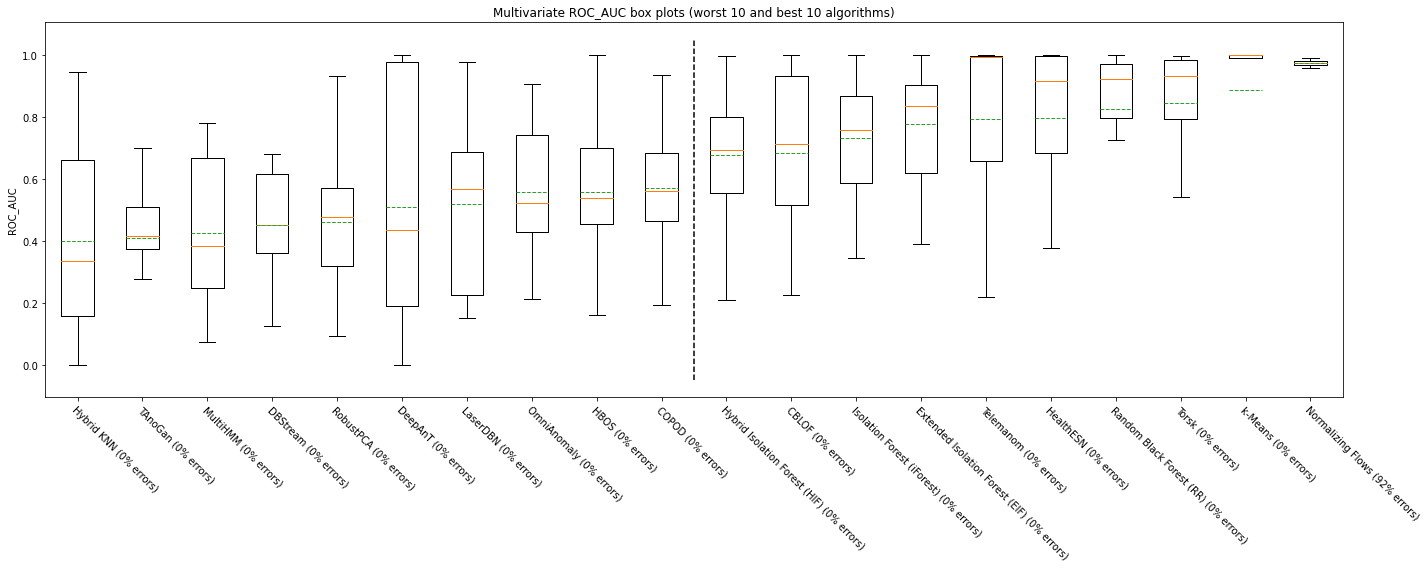

In [25]:
n_show = len(df_multi_asl.columns)
n_show = n_show // 2

df_multi_error_counts = df_multi.pivot_table(index="algorithm", columns="status", values="repetition", aggfunc="count")
df_multi_error_counts["ALL"] = df_multi_error_counts.sum(axis=1)
df_multi_error_counts["ERROR"] = (df_multi_error_counts["Status.ERROR"] + df_multi_error_counts["Status.TIMEOUT"])
df_multi_error_counts = df_multi_error_counts.fillna(value=0).astype(np.int64).sort_values("Status.ERROR", ascending=False)
fmt_label = lambda c: f"{c} ({df_multi_error_counts.loc[c, 'ERROR']/df_multi_error_counts.loc[c, 'ALL']:.0%} errors)"

fig = plot_boxplot(df_multi_asl, title="Multivariate ROC_AUC box plots", ax_label="ROC_AUC", fmt_label=fmt_label)

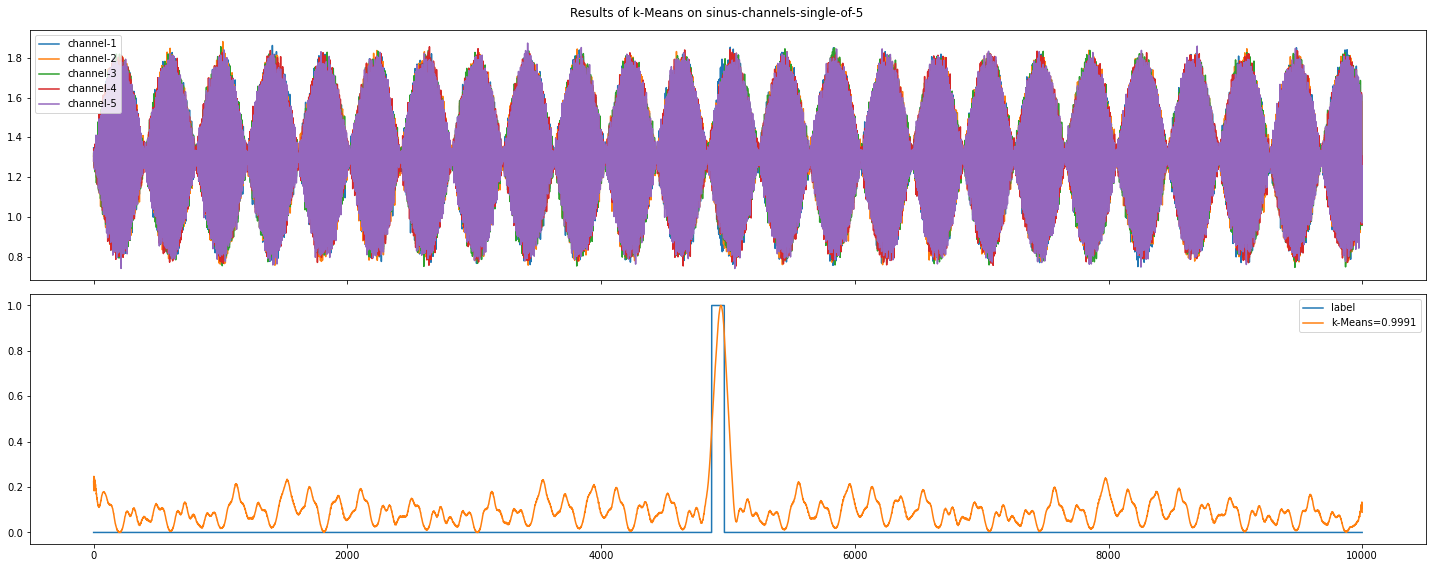

In [26]:
fig = plot_scores("k-Means", "sinus-channels-single-of-5")

## Detailed analysis of certain algorithm or dataset aspects

In [27]:
method_families = ["forecasting", "reconstruction", "distribution", "trees", "distance", "compression", "baseline"]
algo_metadata = [
  {"name": "AD-LTI", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "ARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Autoencoder (AE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Bagel", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "CBLOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COPOD", "research_area": "Ourlier Detection", "method_family": "distribution"},
  {"name": "DenoisingAutoEncoder (DAE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DBStream", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "DeepAnT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "DeepNAP", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Donut", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DSPOT", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "DWT-MLEAD", "research_area": "Signal Analysis", "method_family": "distribution"},
  {"name": "Extended Isolation Forest (EIF)", "research_area": "Classic Machine Learning", "method_family": "trees"},
  {"name": "EncDec-AD", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Ensemble GI", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "FFT", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "Random Forest Regressor (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "XGBoosting (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "GrammarViz", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "HBOS", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "HealthESN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Hybrid Isolation Forest (HIF)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "HOT SAX", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Hybrid KNN", "research_area": "Deep Learning", "method_family": "distance"},
  {"name": "IF-LOF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Isolation Forest (iForest)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "ImageEmbeddingCAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "k-Means", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "KNN", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "LaserDBN", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "Left STAMPi", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "LSTM-AD", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "LSTM-VAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MedianMethod", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "MSCRED", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MTAD-GAT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "MultiHMM", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "NormA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Normalizing Flows", "research_area": "Deep Learning", "method_family": "distribution"},
  {"name": "NoveltySVR", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "NumentaHTM", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OceanWNN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OmniAnomaly", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "PCC", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "PCI", "research_area": "Statistics (Regression & Forecasting)", "method_family": "reconstruction"},
  {"name": "PhaseSpace-SVM", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "PST", "research_area": "Data Mining", "method_family": "trees"},
  {"name": "Random Black Forest (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "RobustPCA", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "S-H-ESD (Twitter)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "SAND", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "SARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Series2Graph", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Spectral Residual (SR)", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "SR-CNN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "SSA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STAMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STOMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Subsequence Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "Subsequence IF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Subsequence LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "TAnoGAN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "TARZAN", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Telemanom", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Torsk", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Triple ES (Holt-Winter's)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "TSBitmap", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "VALMOD", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "normal", "research_area": "None", "method_family": "baseline"},
  {"name": "Random", "research_area": "None", "method_family": "baseline"},
  {"name": "increasing", "research_area": "None", "method_family": "baseline"},
]

algo_meta_lut = {}
for obj in algo_metadata:
    algo_meta_lut[obj["name"]] = obj
# fix some typos:
algo_meta_lut["TAnoGan"] = algo_meta_lut["TAnoGAN"]
algo_meta_lut["random"] = algo_meta_lut["Random"]

In [28]:
from matplotlib import cm

def get_color_by_family(algorithm_name):
    family = algo_meta_lut[algorithm_name]["method_family"]
    return cm.Pastel1(method_families.index(family))

### Best algorithms for base oscillations

Find dataset names:

In [29]:
dataset_names = df_asl.index
sine_datasets = dataset_names[dataset_names.str.startswith("sinus")]
rw_datasets = dataset_names[dataset_names.str.startswith("rw")]
cbf_datasets = dataset_names[dataset_names.str.startswith("cbf")]
ecg_datasets = dataset_names[dataset_names.str.startswith("ecg")]
poly_datasets = dataset_names[dataset_names.str.startswith("poly")]

#### Sine

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


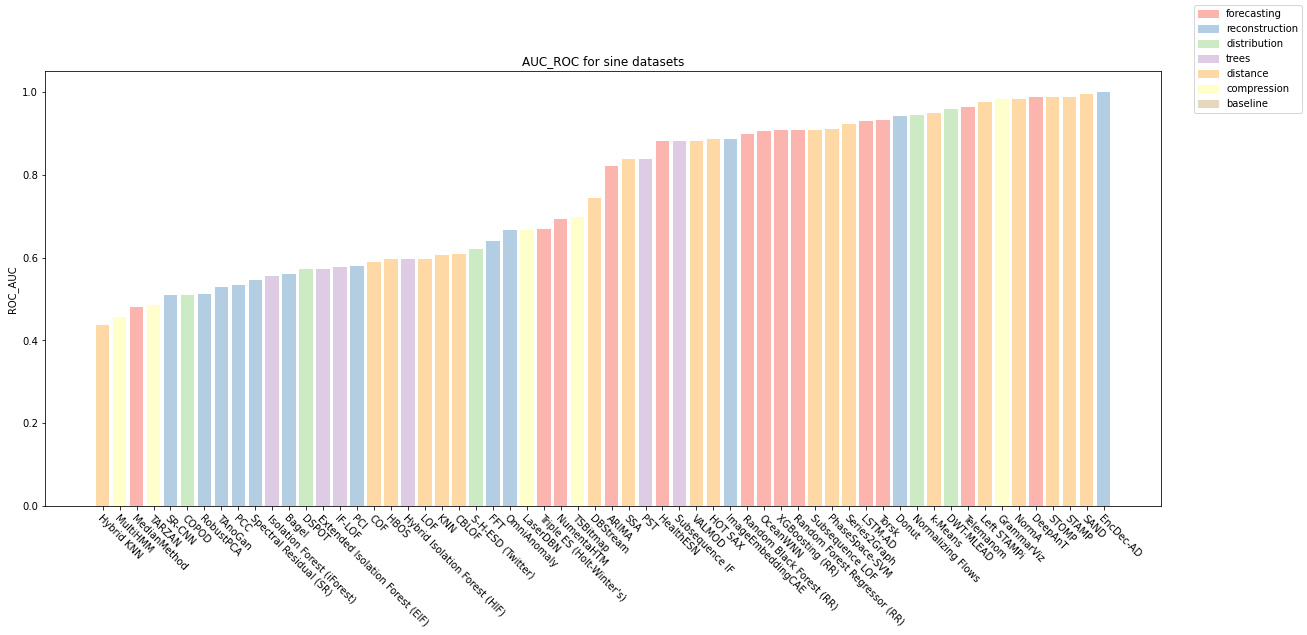

In [30]:
df_tmp = pd.DataFrame(df_asl.loc[sine_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for sine datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### ECG

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


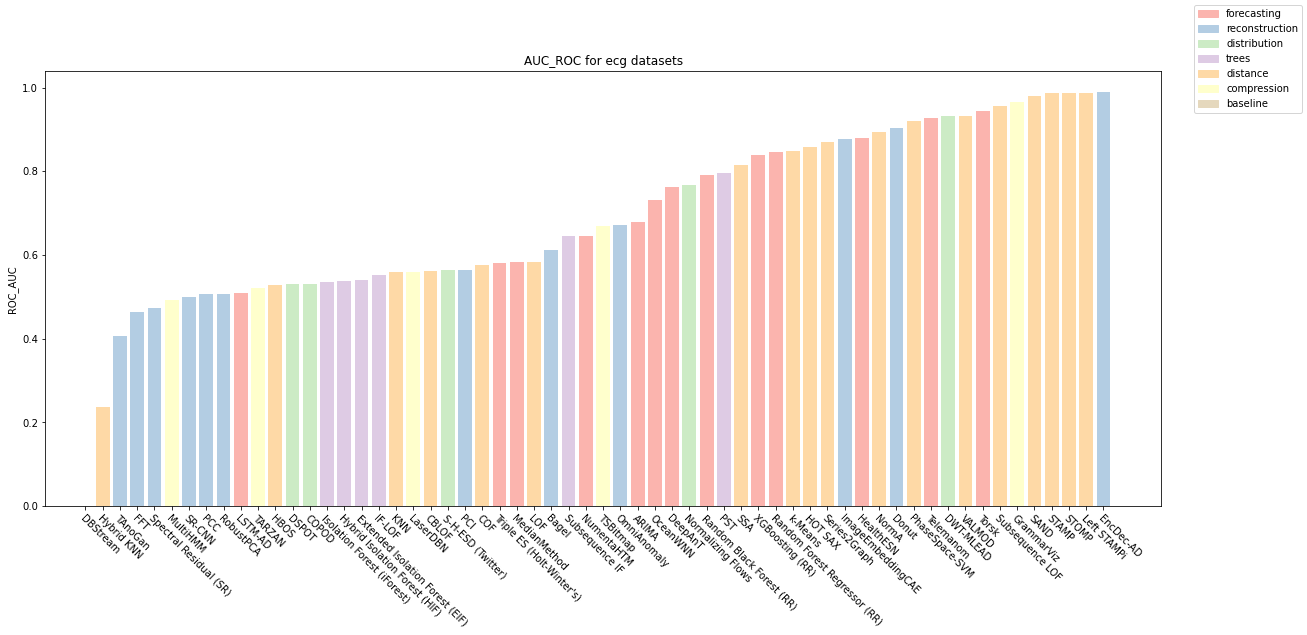

In [31]:
df_tmp = pd.DataFrame(df_asl.loc[ecg_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for ecg datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Random Walk

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


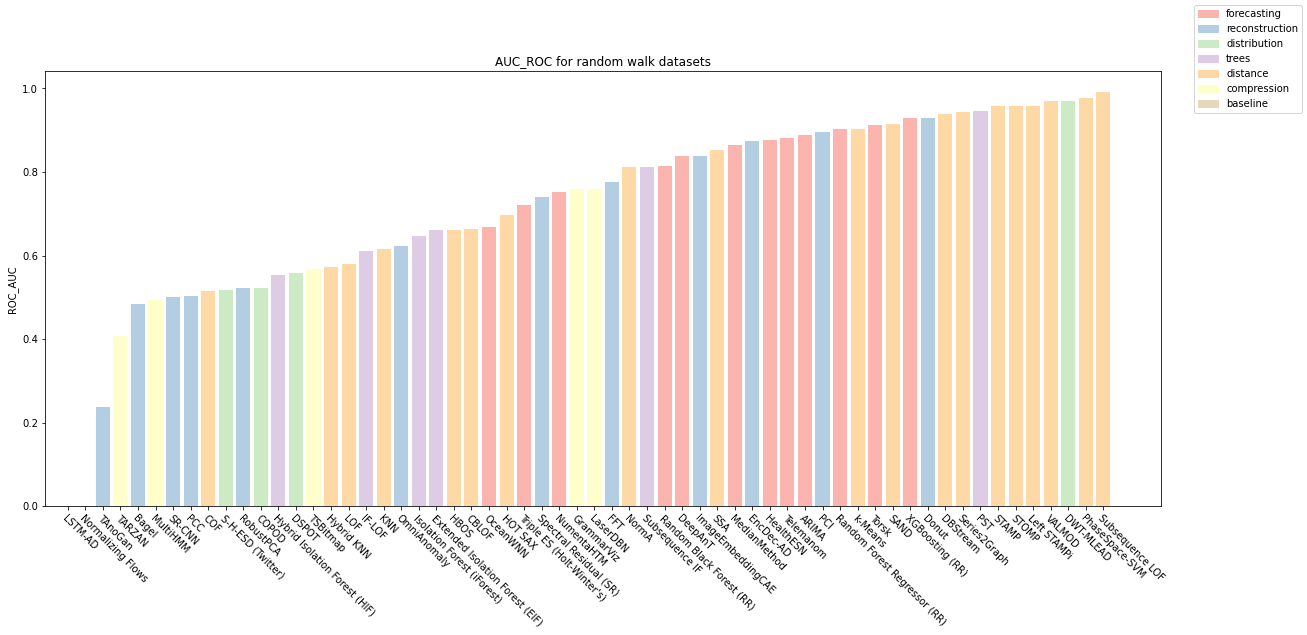

In [32]:
df_tmp = pd.DataFrame(df_asl.loc[rw_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for random walk datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### CBF

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


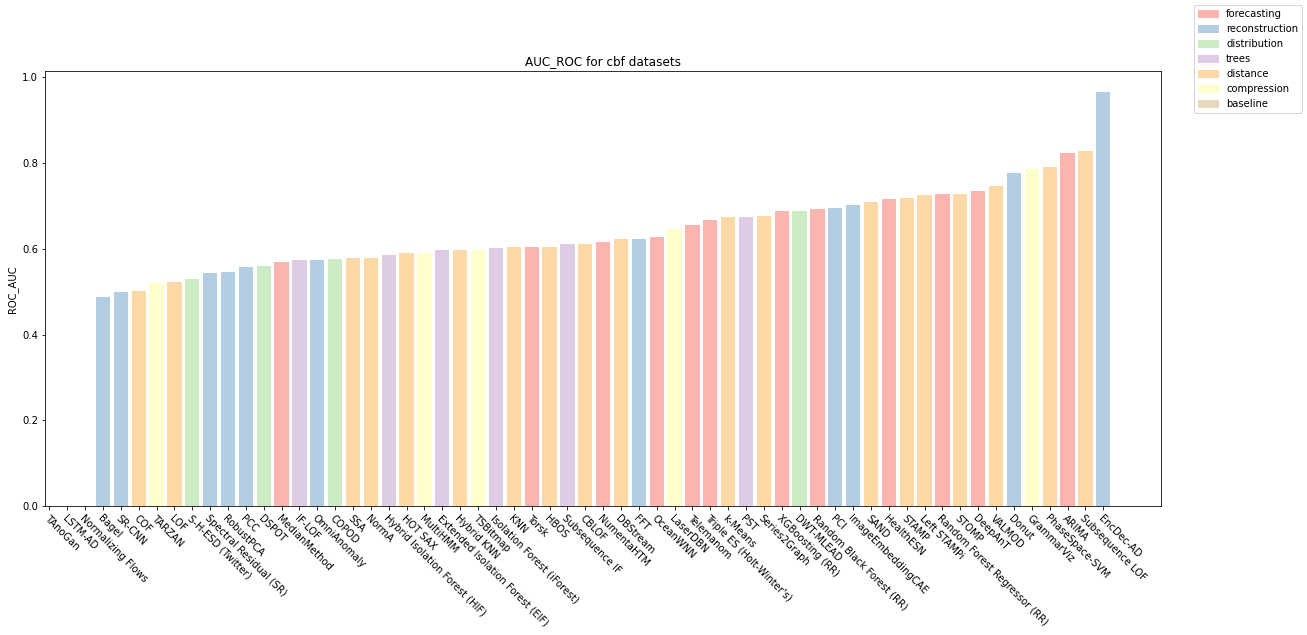

In [33]:
df_tmp = pd.DataFrame(df_asl.loc[cbf_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for cbf datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Poly

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


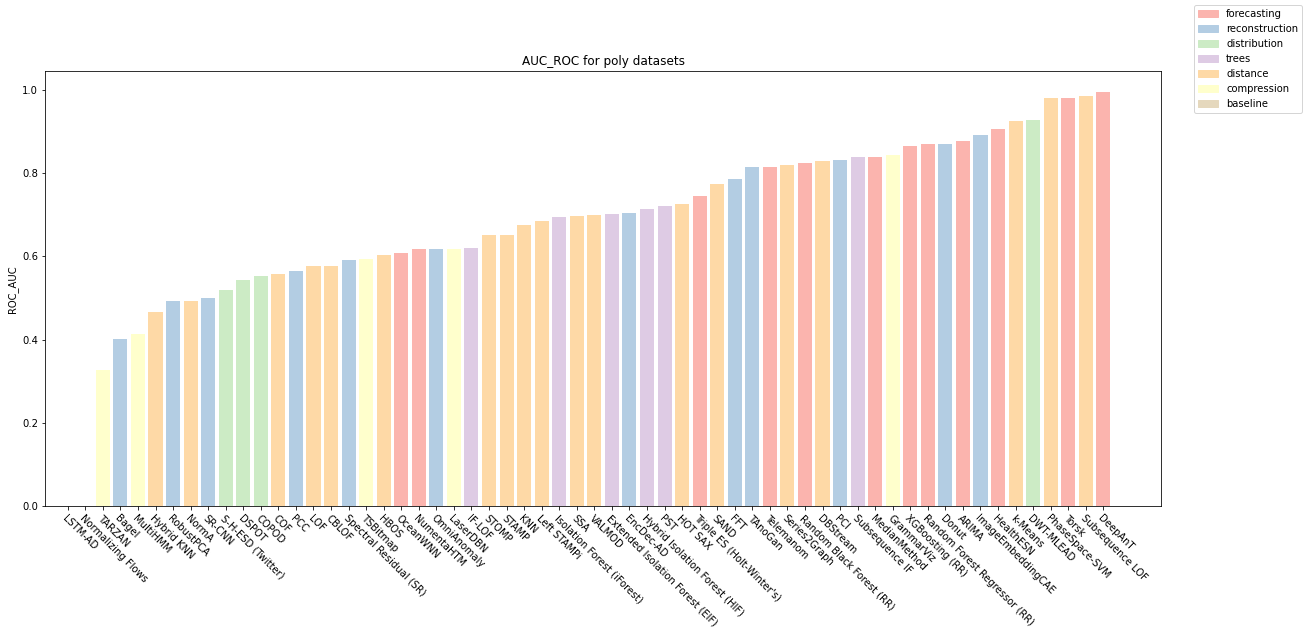

In [34]:
df_tmp = pd.DataFrame(df_asl.loc[poly_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for poly datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

### Best algorithms for anomaly type

Find dataset names:

In [35]:
dataset_names = df_asl.index
def get_dataset_names_by_anomaly_type(anomaly_type):
    return dataset_names[dataset_names.str.contains(anomaly_type)]

#### Extremum

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


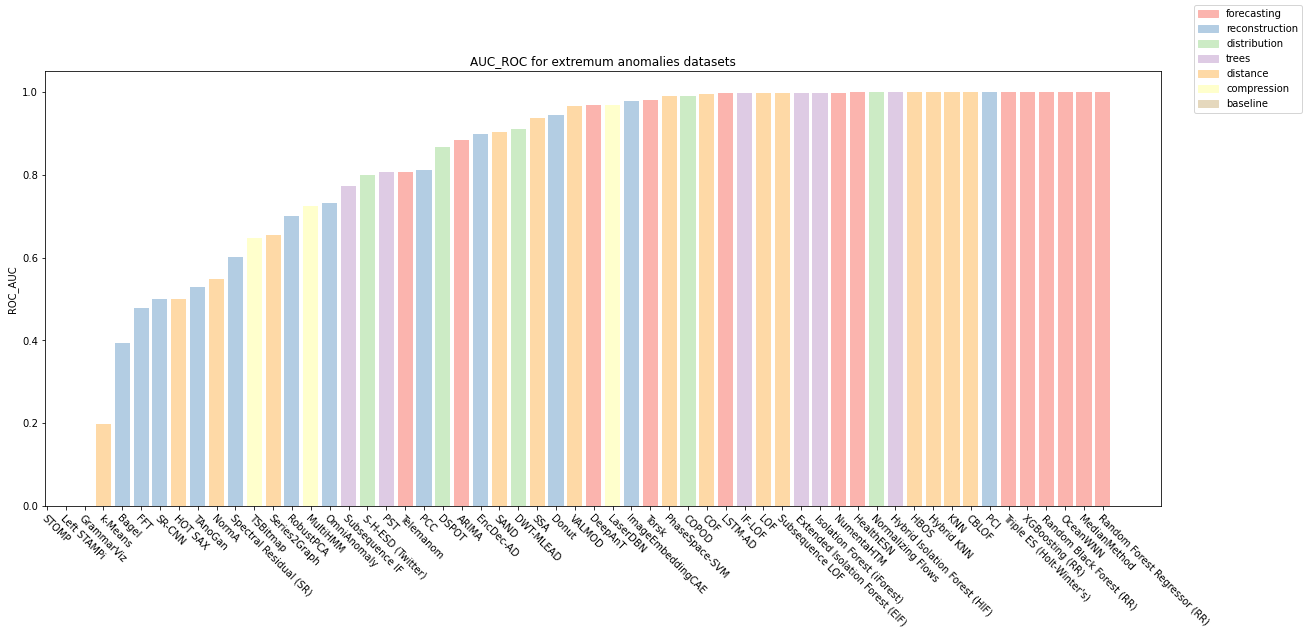

In [36]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("extremum")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for extremum anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Frequency

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


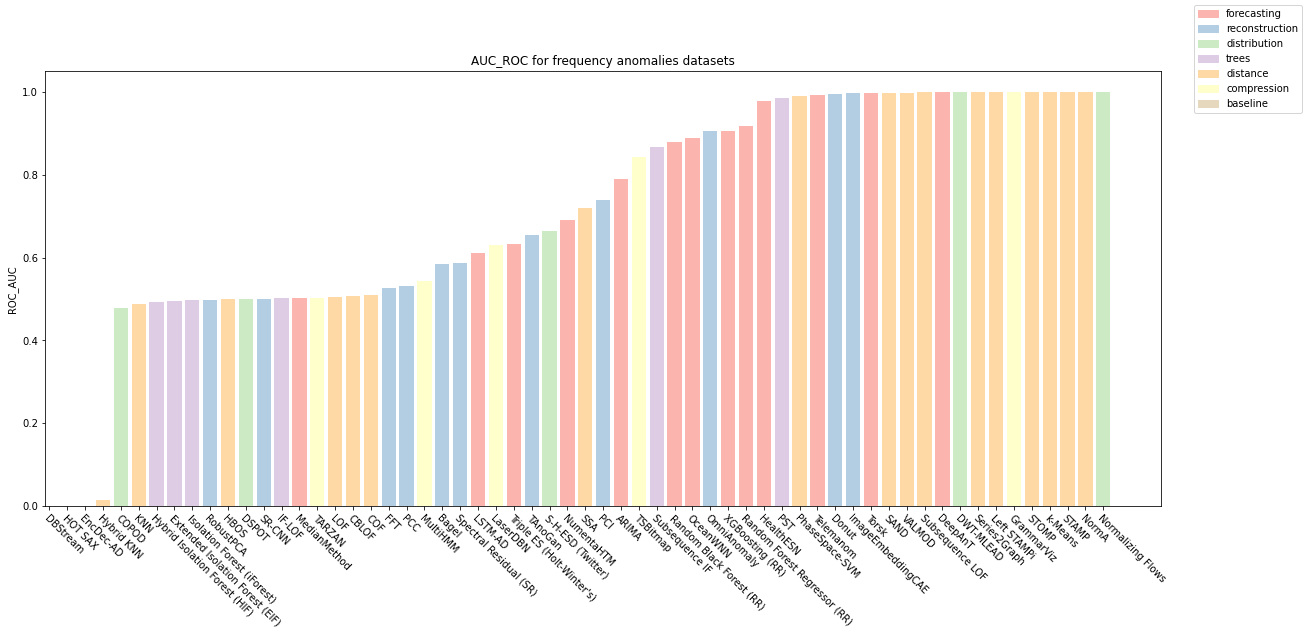

In [37]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("frequency")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for frequency anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

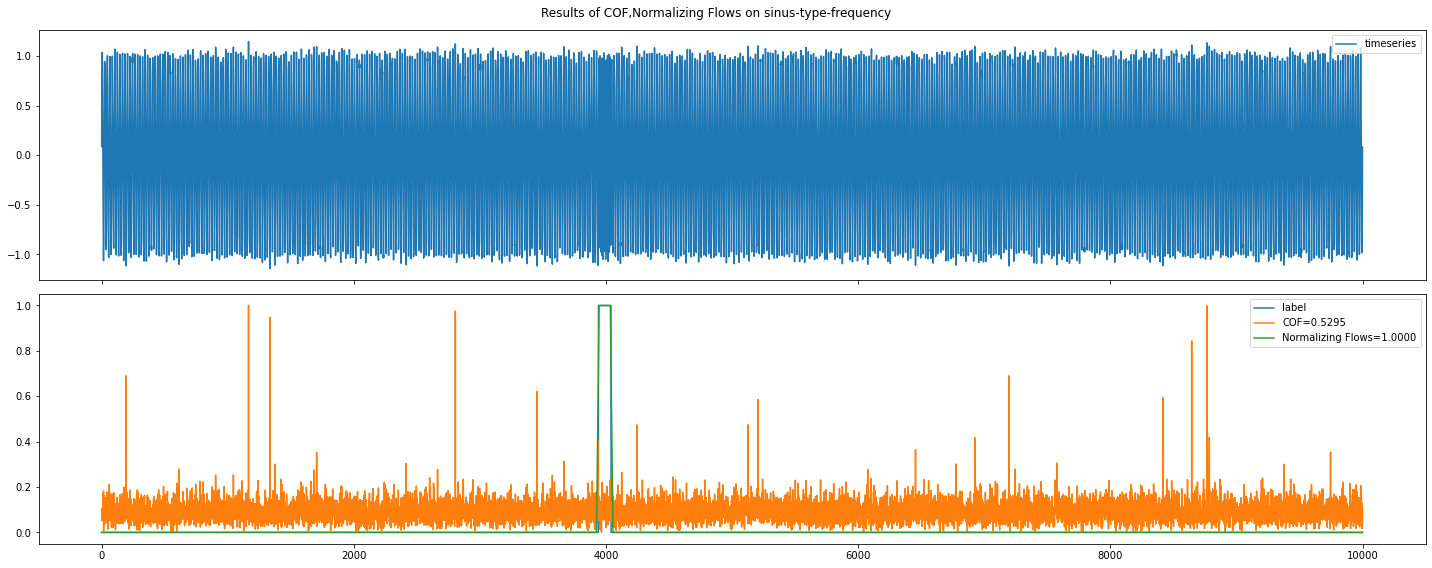

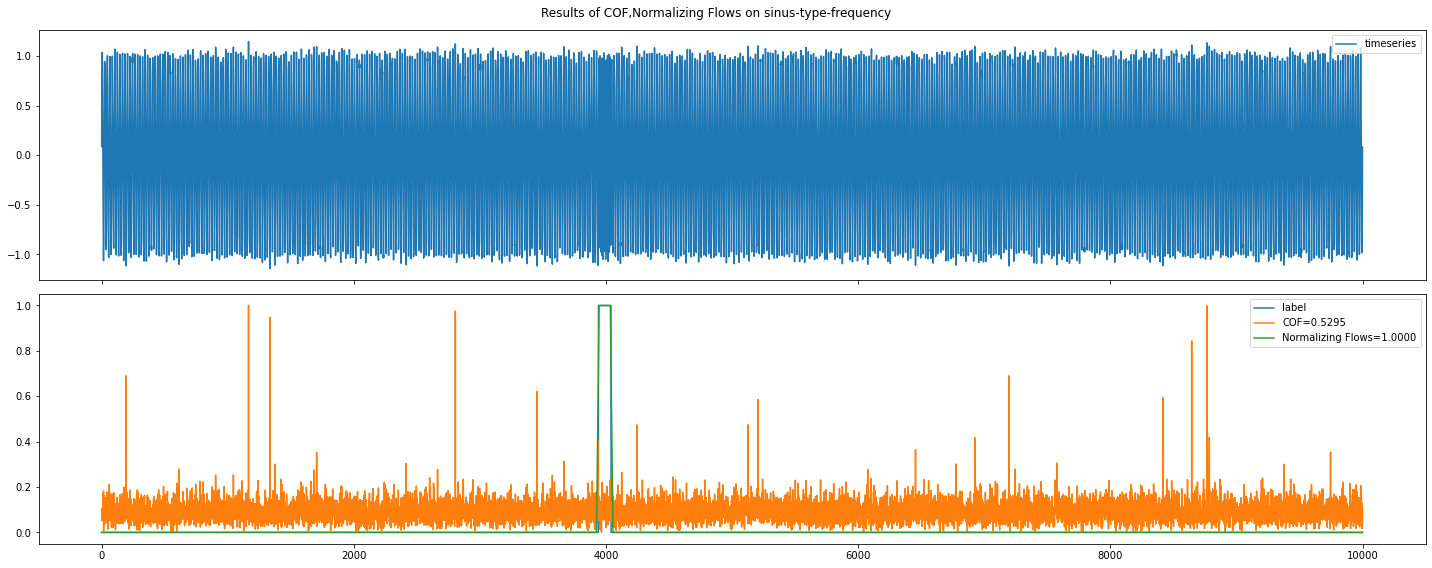

In [38]:
plot_scores(["COF", "Normalizing Flows"], "sinus-type-frequency")

#### Mean Shift

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


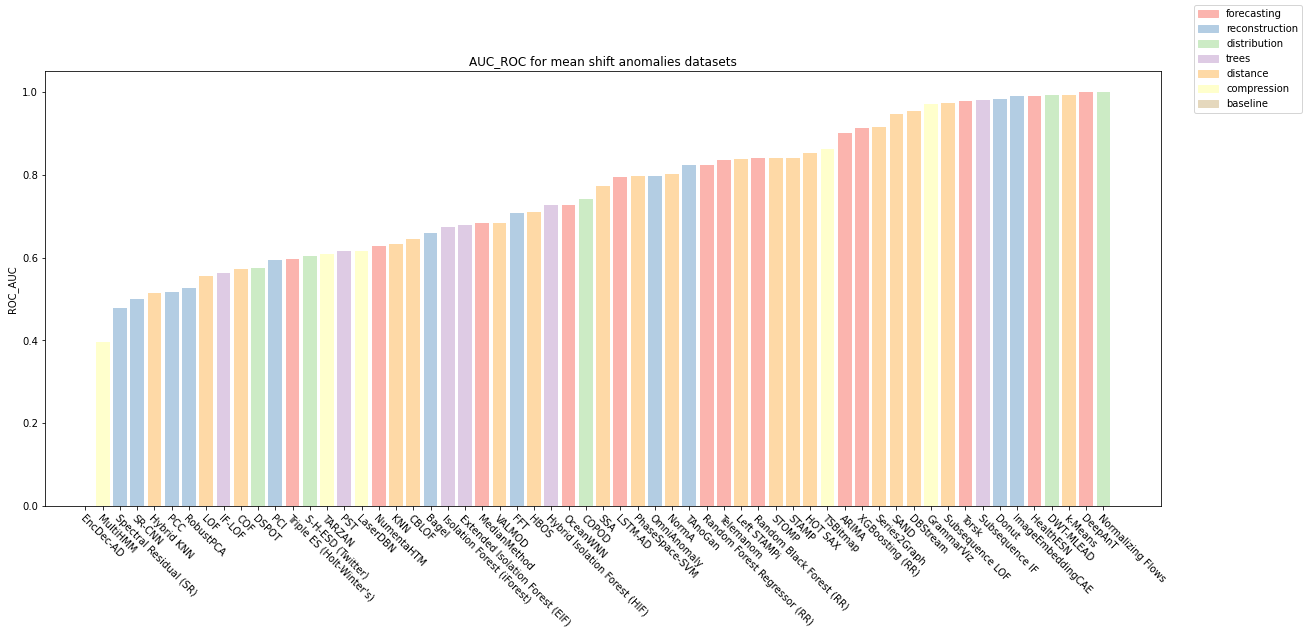

In [39]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("mean")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for mean shift anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Pattern

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


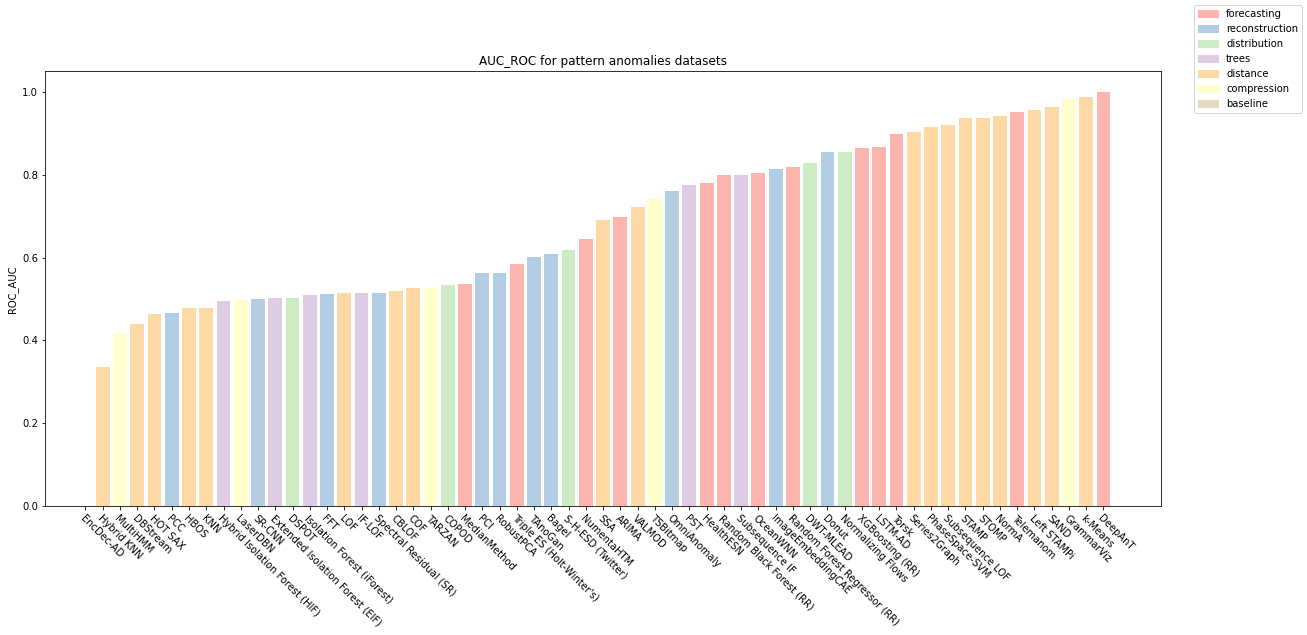

In [40]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("pattern")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for pattern anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Pattern Shift

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


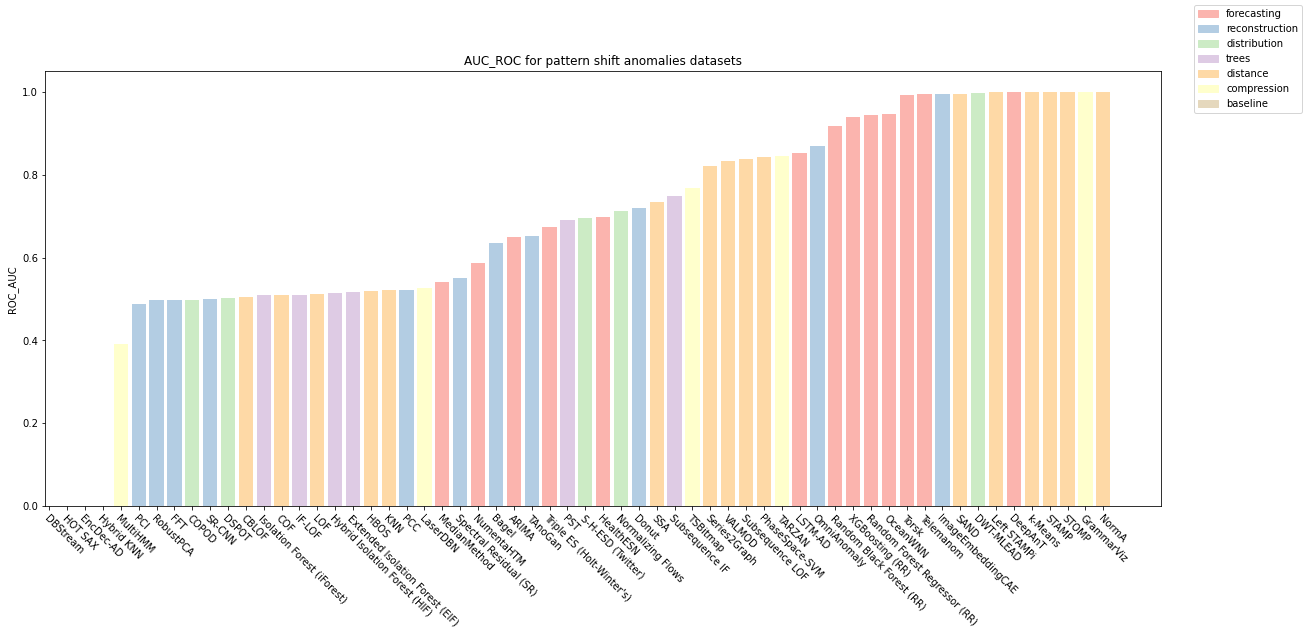

In [41]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("pattern-shift")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for pattern shift anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Platform

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


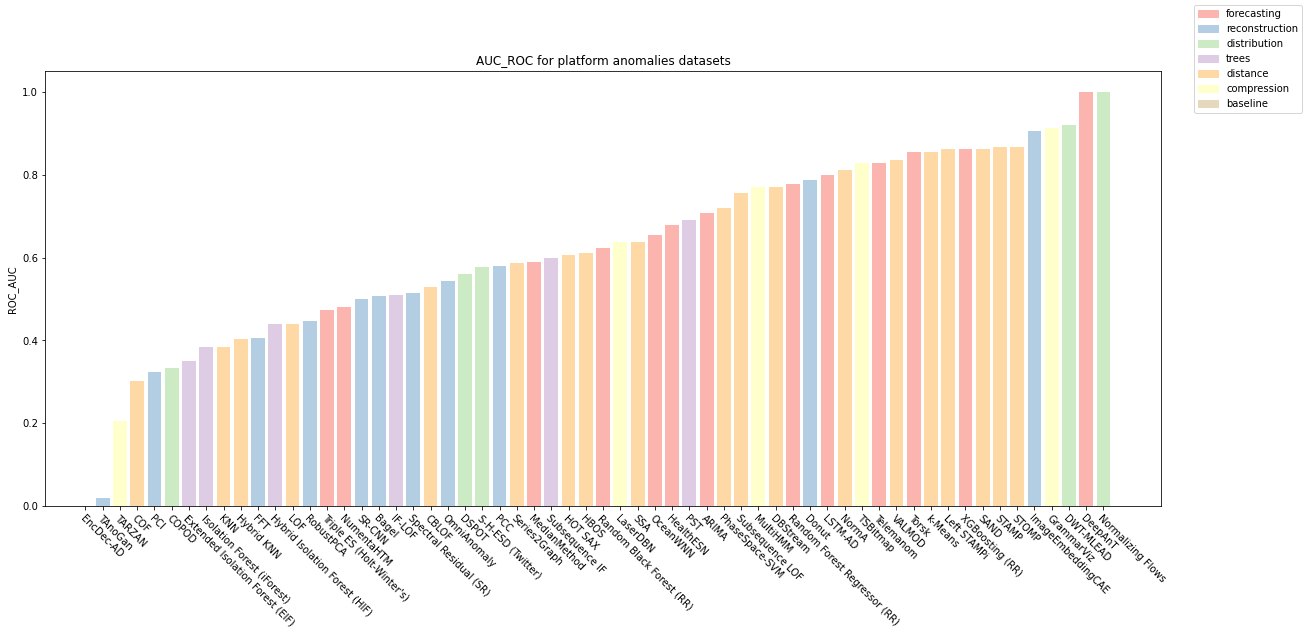

In [42]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("platform")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for platform anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Variance

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


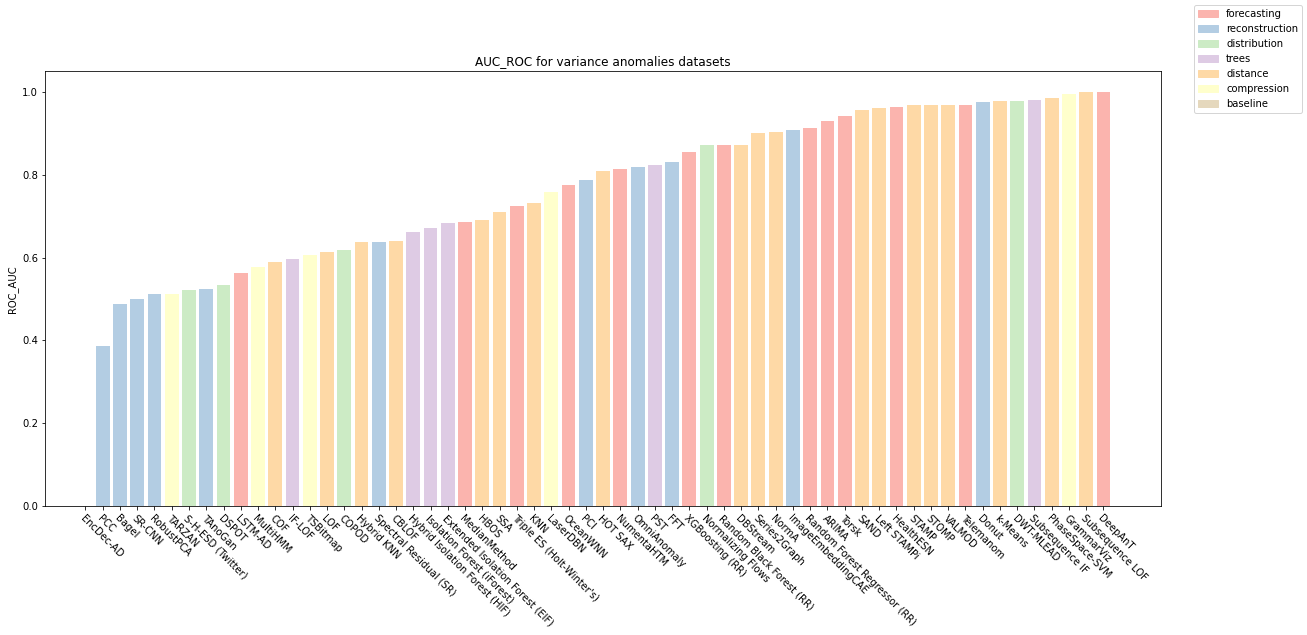

In [43]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("variance")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for variance anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Amplitude

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


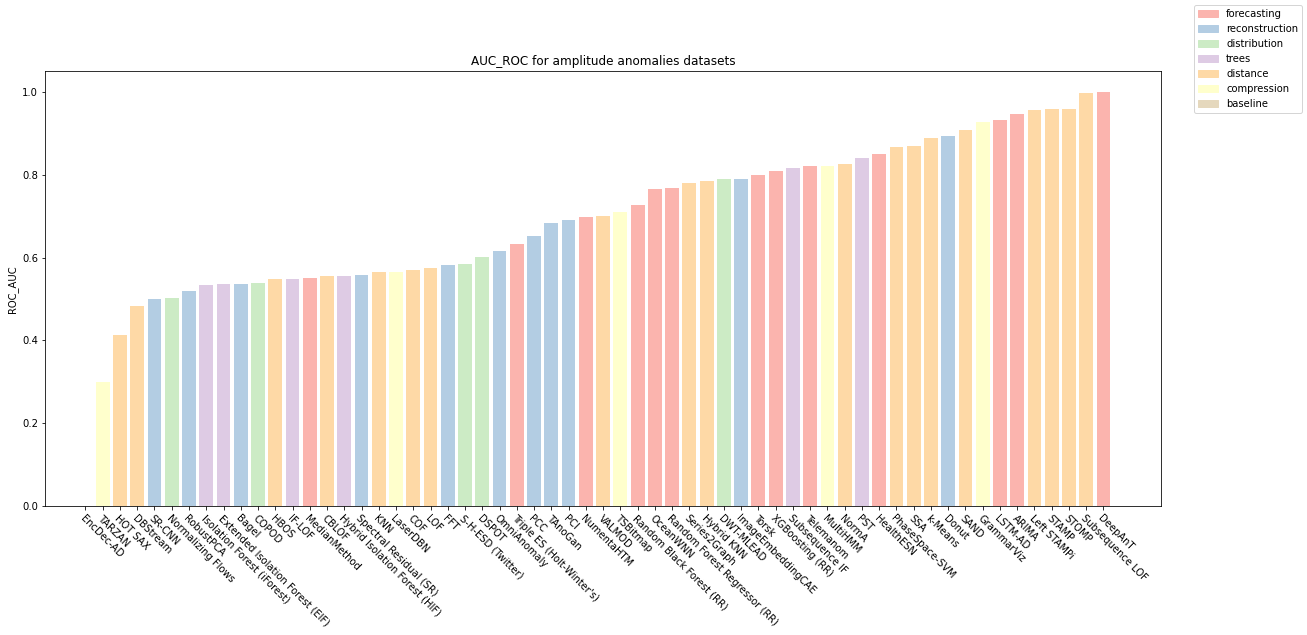

In [44]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("amplitude")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for amplitude anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Trend

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


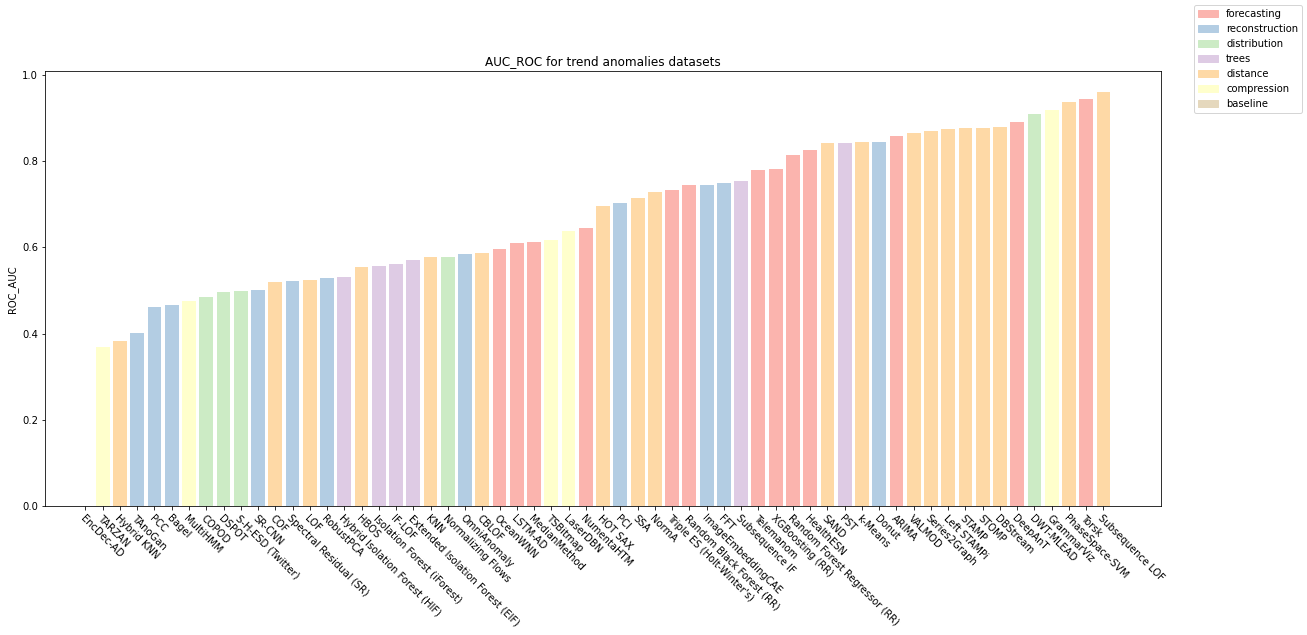

In [45]:
df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type("trend")].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for trend anomalies datasets", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

#### Most fluctuating algorithms based on anomaly type

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


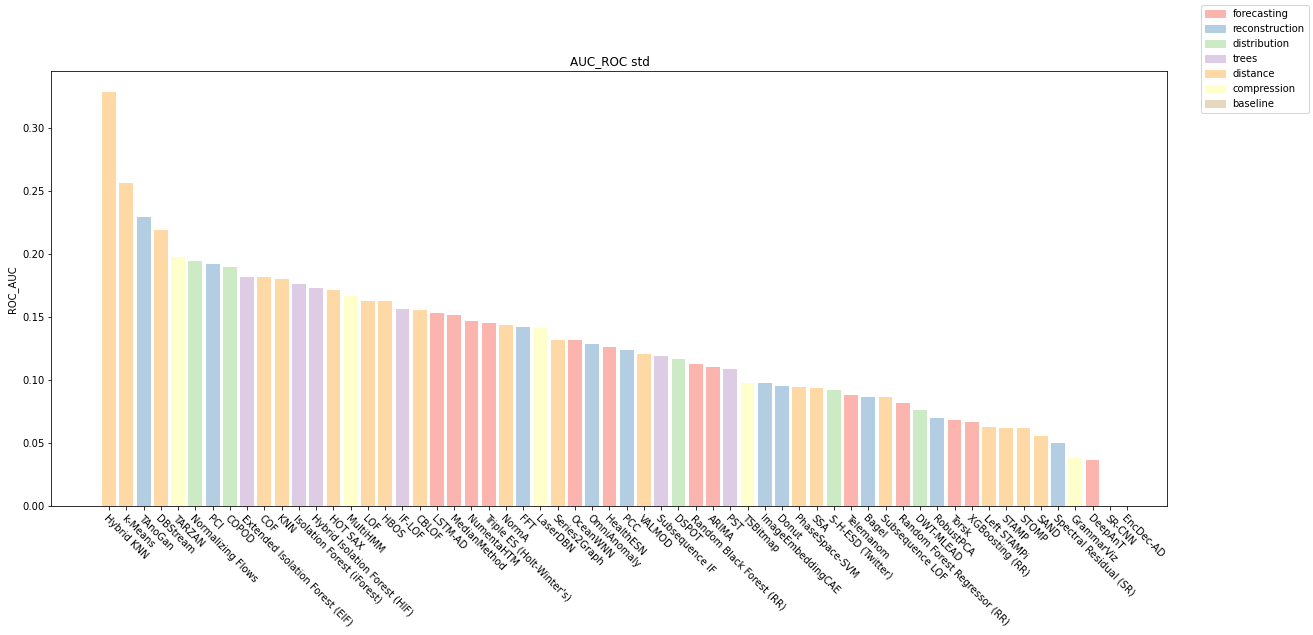

In [46]:
from functools import reduce
anomaly_types = ["amplitude", "extremum", "frequency", "mean", "pattern", "pattern-shift", "platform", "trend", "variance"]

df_tmp_anomaly_types = []
for anomaly_type in anomaly_types:
    df_tmp = pd.DataFrame(df_asl.loc[get_dataset_names_by_anomaly_type(anomaly_type)].mean(), columns=["ROC_AUC"])
    df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first")
    df_tmp.rename(columns={"ROC_AUC": anomaly_type}, inplace=True)
    df_tmp_anomaly_types.append(df_tmp)
df_tmp_anomaly_types = reduce(lambda a, b: a.join(b), df_tmp_anomaly_types)

df_tmp = df_tmp_anomaly_types.std(axis=1).reset_index(name="ROC_AUC").sort_values(by="ROC_AUC", ascending=False)

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC std", color=[get_color_by_family(algo) for algo in df_tmp["algorithm"]], legend=False)
fig.legend([plt.Rectangle((0,0),1,1, color=cm.Pastel1(i)) for i, _ in enumerate(method_families)], method_families)

### Best algorithms for single/multiple-same/multiple-different anomalies

Find dataset names:

In [47]:
dataset_names = df_asl.index
single_anomaly_datasets = dataset_names[dataset_names.str.contains("count-1")]
same_anomaly_datasets = dataset_names[(dataset_names.str.contains("same-count")) & ~(dataset_names.str.contains("count-1"))]
diff_anomaly_datasets = dataset_names[(dataset_names.str.contains("diff-count")) & ~(dataset_names.str.contains("count-1"))]

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


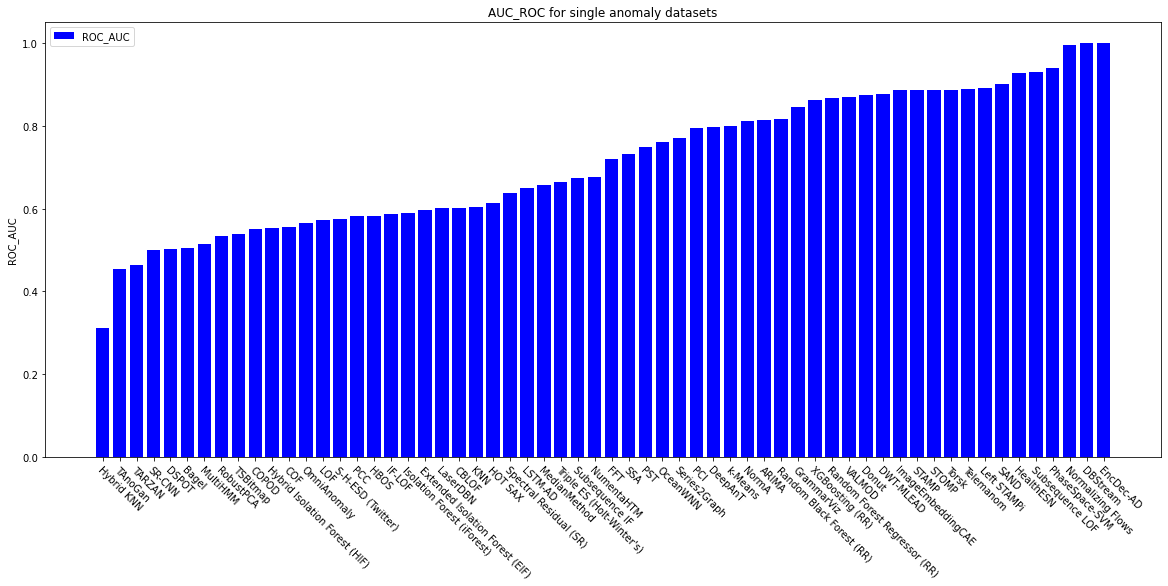

In [48]:
df_tmp = pd.DataFrame(df_asl.loc[single_anomaly_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for single anomaly datasets")

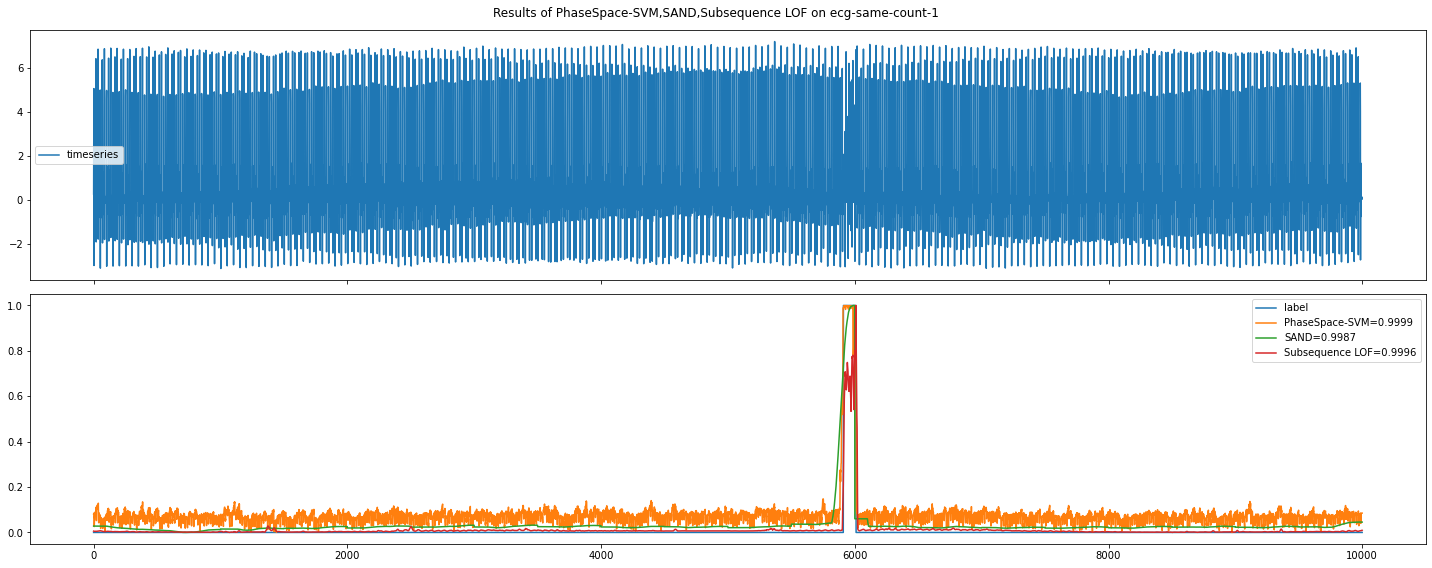

In [49]:
fig = plot_scores(["PhaseSpace-SVM", "SAND", "Subsequence LOF"], "ecg-same-count-1")

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


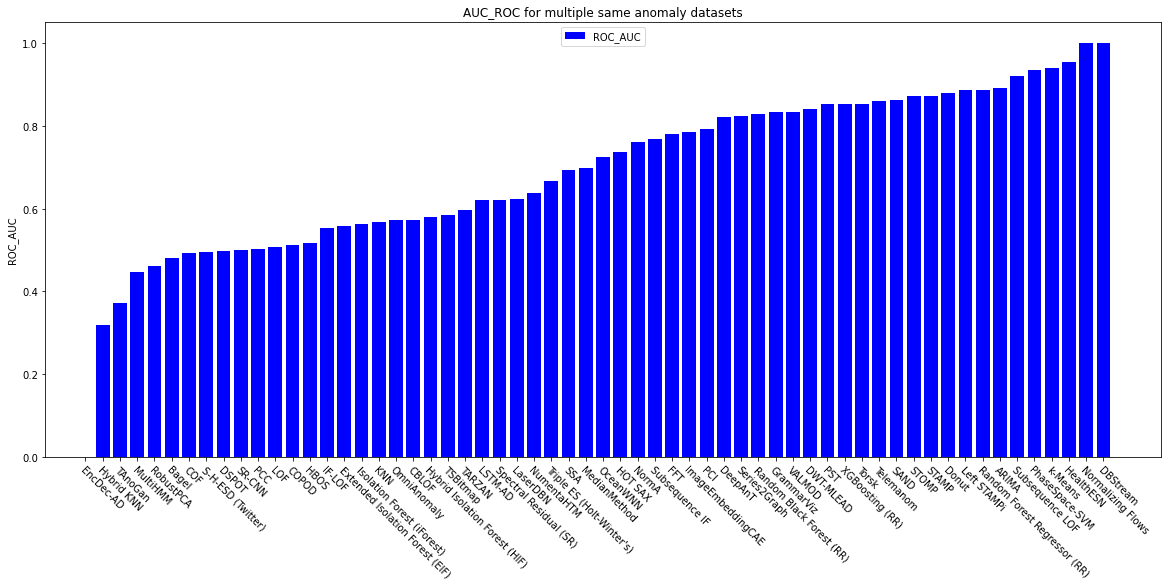

In [50]:
df_tmp = pd.DataFrame(df_asl.loc[same_anomaly_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for multiple same anomaly datasets")

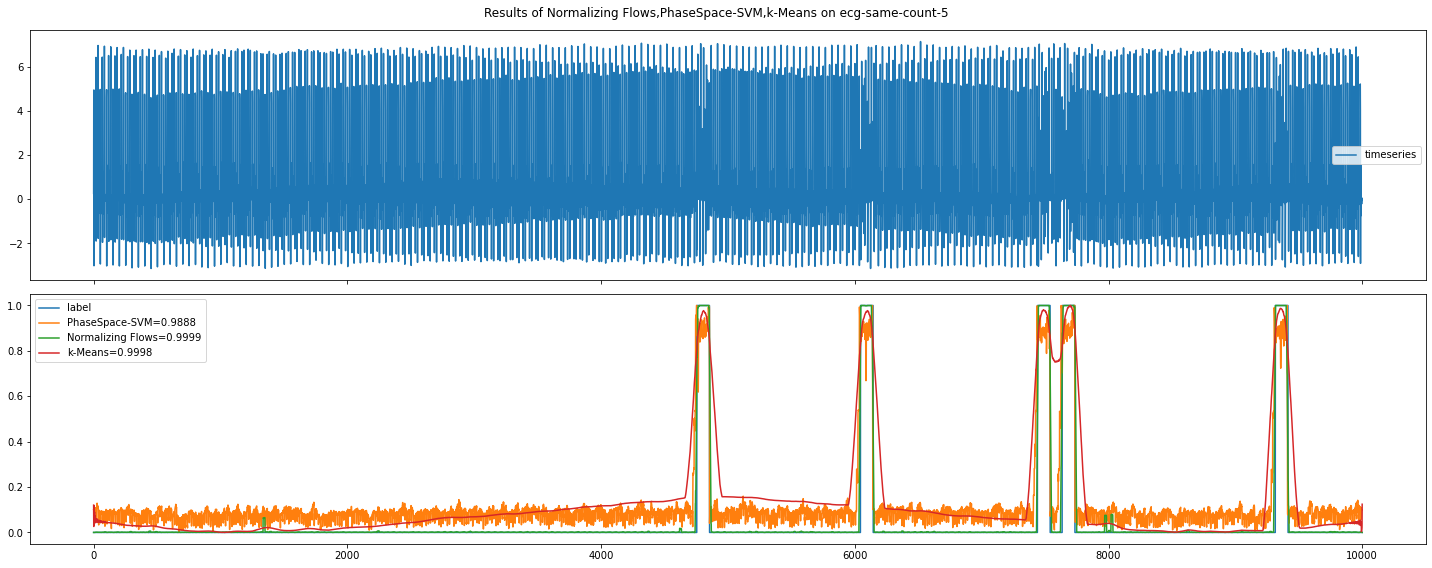

In [51]:
fig = plot_scores(["PhaseSpace-SVM", "Normalizing Flows", "k-Means"], "ecg-same-count-5")

/tmp/ipykernel_6139/3316162823.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["algorithm"], rotation=-45, ha="left", rotation_mode="anchor")


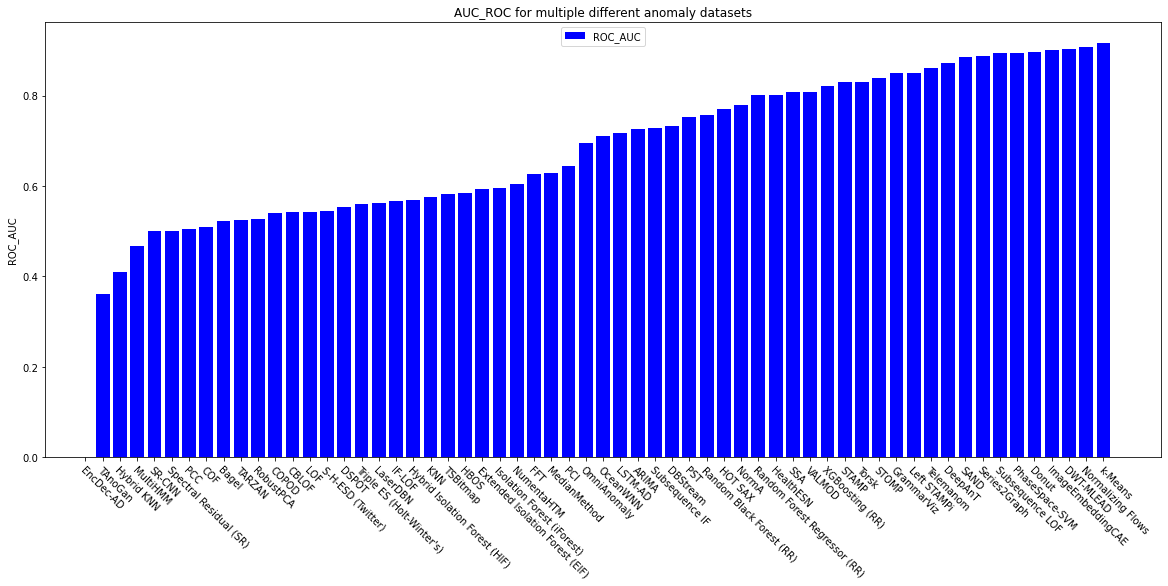

In [52]:
df_tmp = pd.DataFrame(df_asl.loc[diff_anomaly_datasets].mean(), columns=["ROC_AUC"])
df_tmp = df_tmp.sort_values(by="ROC_AUC", na_position="first").reset_index()

fig = plot_algorithm_bars(df_tmp, y_name="ROC_AUC", title="AUC_ROC for multiple different anomaly datasets")

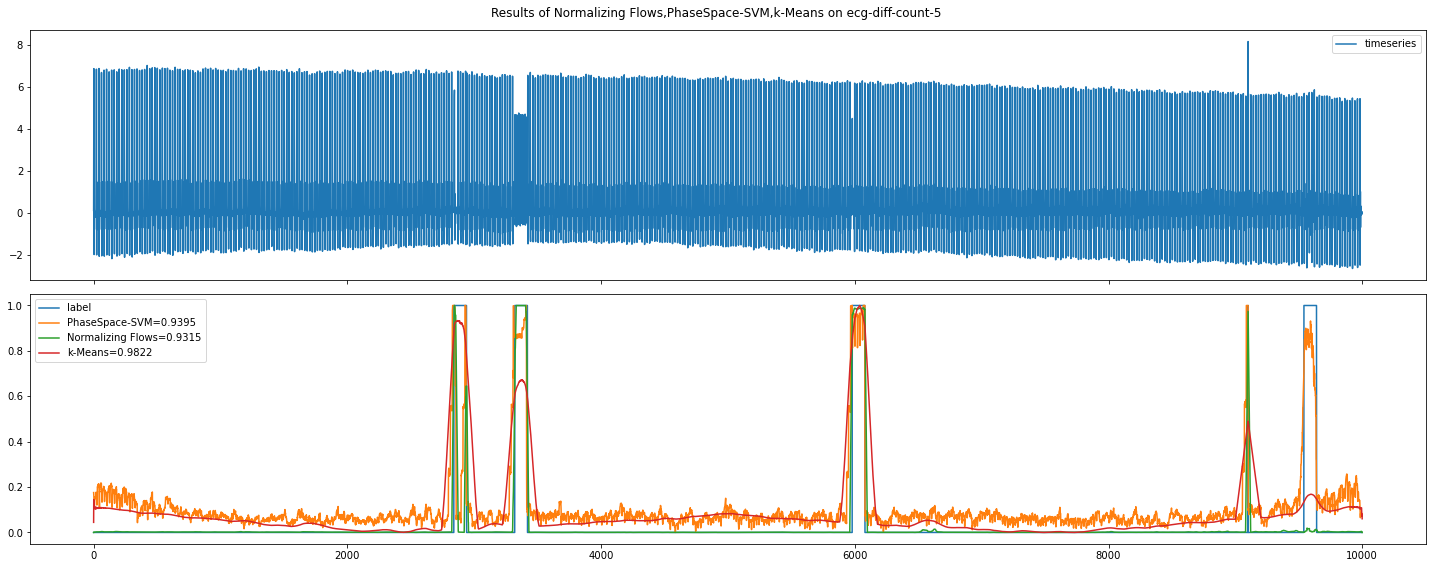

In [53]:
fig = plot_scores(["PhaseSpace-SVM", "Normalizing Flows", "k-Means"], "ecg-diff-count-5")

### Best algorithm for series with trend

### Best algorithm of algorithm family

In [54]:
algo_metadata = [
  {"name": "AD-LTI", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "ARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Autoencoder (AE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Bagel", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "CBLOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "COPOD", "research_area": "Ourlier Detection", "method_family": "distribution"},
  {"name": "DenoisingAutoEncoder (DAE)", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DBStream", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "DeepAnT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "DeepNAP", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Donut", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "DSPOT", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "DWT-MLEAD", "research_area": "Signal Analysis", "method_family": "distribution"},
  {"name": "Extended Isolation Forest (EIF)", "research_area": "Classic Machine Learning", "method_family": "trees"},
  {"name": "EncDec-AD", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "Ensemble GI", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "FFT", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "Random Forest Regressor (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "XGBoosting (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "GrammarViz", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "HBOS", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "HealthESN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Hybrid Isolation Forest (HIF)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "HOT SAX", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Hybrid KNN", "research_area": "Deep Learning", "method_family": "distance"},
  {"name": "IF-LOF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Isolation Forest (iForest)", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "ImageEmbeddingCAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "k-Means", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "KNN", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "LaserDBN", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "Left STAMPi", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "LSTM-AD", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "LSTM-VAE", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MedianMethod", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "MSCRED", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "MTAD-GAT", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "MultiHMM", "research_area": "Stochastic Learning", "method_family": "compression"},
  {"name": "NormA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Normalizing Flows", "research_area": "Deep Learning", "method_family": "distribution"},
  {"name": "NoveltySVR", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "NumentaHTM", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OceanWNN", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "OmniAnomaly", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "PCC", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "PCI", "research_area": "Statistics (Regression & Forecasting)", "method_family": "reconstruction"},
  {"name": "PhaseSpace-SVM", "research_area": "Classic Machine Learning", "method_family": "distance"},
  {"name": "PST", "research_area": "Data Mining", "method_family": "trees"},
  {"name": "Random Black Forest (RR)", "research_area": "Classic Machine Learning", "method_family": "forecasting"},
  {"name": "RobustPCA", "research_area": "Classic Machine Learning", "method_family": "reconstruction"},
  {"name": "S-H-ESD (Twitter)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "SAND", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "SARIMA", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "Series2Graph", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Spectral Residual (SR)", "research_area": "Signal Analysis", "method_family": "reconstruction"},
  {"name": "SR-CNN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "SSA", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STAMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "STOMP", "research_area": "Data Mining", "method_family": "distance"},
  {"name": "Subsequence Fast-MCD", "research_area": "Statistics (Regression & Forecasting)", "method_family": "distribution"},
  {"name": "Subsequence IF", "research_area": "Ourlier Detection", "method_family": "trees"},
  {"name": "Subsequence LOF", "research_area": "Ourlier Detection", "method_family": "distance"},
  {"name": "TAnoGAN", "research_area": "Deep Learning", "method_family": "reconstruction"},
  {"name": "TARZAN", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "Telemanom", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Torsk", "research_area": "Deep Learning", "method_family": "forecasting"},
  {"name": "Triple ES (Holt-Winter's)", "research_area": "Statistics (Regression & Forecasting)", "method_family": "forecasting"},
  {"name": "TSBitmap", "research_area": "Data Mining", "method_family": "compression"},
  {"name": "VALMOD", "research_area": "Data Mining", "method_family": "distance"},
]

algo_meta_lut = {}
for obj in algo_metadata:
    algo_meta_lut[obj["name"]] = obj
# fix some typos:
algo_meta_lut["TAnoGan"] = algo_meta_lut["TAnoGAN"]

df["algo_family"] = df["algorithm"].apply(lambda algo: algo_meta_lut[algo]["method_family"])
df["algo_area"] = df["algorithm"].apply(lambda algo: algo_meta_lut[algo]["research_area"])
df.pivot_table(index="algo_family", columns="algorithm", values="ROC_AUC", aggfunc="mean")

algorithm,ARIMA,Bagel,CBLOF,COF,COPOD,DBStream,DSPOT,DWT-MLEAD,DeepAnT,Donut,...,Subsequence LOF,TARZAN,TAnoGan,TSBitmap,Telemanom,Torsk,Triple ES (Holt-Winter's),VALMOD,XGBoosting (RR),k-Means
algo_family,,,,,,,,,,,,,,,,,,,,,
compression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.478378,NaN,0.634313,NaN,NaN,NaN,NaN,NaN,NaN
distance,NaN,NaN,0.602738,0.55094,NaN,0.709822,NaN,NaN,NaN,NaN,...,0.929827,NaN,NaN,NaN,NaN,NaN,NaN,0.853179,NaN,0.860521
distribution,NaN,NaN,NaN,NaN,0.536997,NaN,0.554006,0.896714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forecasting,0.808748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.855186,NaN,...,NaN,NaN,NaN,NaN,0.856924,0.876505,0.668414,NaN,0.845629,NaN
reconstruction,NaN,0.521089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.88719,...,NaN,NaN,0.4679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trees,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Easy or hard datasets per algorithm family

## Dataset assessment

- quality overview
- runtime overview
- datasets, for which the most algorithms fail
- datasets, for which good algorithms fail

### Dataset quality assessment based on AUC_ROC

### Dataset runtime assessment

## Other insights

- draw a critical difference diagram (cd-diagram) using Wilcoxon-Holm tests: https://github.com/hfawaz/cd-diagram
- algorithms that get good results, but run into timeouts often